# Load Packages


In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku
!pip install jaxopt
!pip install optax

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-oq__titv
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-oq__titv
  Resolved https://github.com/deepmind/dm-haiku to commit 54a1ebaa1c8387cd34114f4e0901e628bec92504
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.13.dev0-py3-none-any.whl size=373908 sha256=425cdd2479203a68c99c3b16538fe90236311d652e9d3a22b8aecdf1579e41e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-x1w_bidc/wheels/b1/df/f1/a357fa8f00c36052bdae1e1fd363650c0bd1e8c3959487b6fb
Successfully built dm-haiku
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import subprocess
import functools
from typing import List, Optional, Iterator, NamedTuple, Any
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
from jax import lax
import jaxopt
import optax
import random
import matplotlib.pyplot as plt
from google.colab import files
from pdb import set_trace

# Importing Data

In [ ]:
NUM_PLAYERS = 2
NUM_ACTIONS = 10
NUM_SAMPLES = 2000

rzs_data = []
woa_data = []
dg_data = []
td_data = []
gd_data = []
bo_data = []

rzs_file = np.fromfile(f'drive/MyDrive/Summer_2023_Research/rzs_2000.npy')
rzs_file = jnp.reshape(rzs_file, (NUM_SAMPLES, NUM_ACTIONS, NUM_ACTIONS, NUM_PLAYERS))
rzs_data = jnp.moveaxis(rzs_file, -1, 1)

woa_file = np.fromfile(f'drive/MyDrive/Summer_2023_Research/woa_2000.npy')
woa_file = jnp.reshape(woa_file, (NUM_SAMPLES, NUM_ACTIONS, NUM_ACTIONS, NUM_PLAYERS))
woa_data = jnp.moveaxis(woa_file, -1, 1)

dg_file = np.fromfile(f'drive/MyDrive/Summer_2023_Research/d_2000.npy')
dg_file = jnp.reshape(dg_file, (NUM_SAMPLES, NUM_ACTIONS, NUM_ACTIONS, NUM_PLAYERS))
dg_data = jnp.moveaxis(dg_file, -1, 1)

td_file = np.fromfile(f'drive/MyDrive/Summer_2023_Research/td_2000.npy')
td_file = jnp.reshape(td_file, (NUM_SAMPLES, NUM_ACTIONS, NUM_ACTIONS, NUM_PLAYERS))
td_data = jnp.moveaxis(td_file, -1, 1)

gd_file = np.fromfile(f'drive/MyDrive/Summer_2023_Research/gd_2000.npy')
gd_file = jnp.reshape(gd_file, (NUM_SAMPLES, NUM_ACTIONS, NUM_ACTIONS, NUM_PLAYERS))
gd_data = jnp.moveaxis(gd_file, -1, 1)

bo_file = np.fromfile(f'drive/MyDrive/Summer_2023_Research/bo_2000.npy')
bo_file = jnp.reshape(bo_file, (NUM_SAMPLES, NUM_ACTIONS, NUM_ACTIONS, NUM_PLAYERS))
bo_data = jnp.moveaxis(bo_file, -1, 1)


#Building the Model

In [ ]:
class GAESTuple(NamedTuple):
  """A tuple of generator and discrminator relevant objects used for the GAES."""
  gen: Any
  disc: Any

class GAESState(NamedTuple):
  """A tuple containing the current state of the generator, discriminator, and
  their respective optimizers.
  """
  params: GAESTuple
  state: GAESTuple
  opt_state: GAESTuple

In [ ]:
class GAES:
  """Generative adverserial equilibrium solver as described in  Goktas et al.
  This solver consists of a generator that predicts an equilibrium and a
  discriminator that best responds to the predicted equilibrium.
  """

  def __init__(self, gen, disc, gen_optimizer, disc_optimizer, distribution, regret_func):
    """Inits the GAES class.
    Args:
      gen: The generator of GAES.
      disc: The discriminator of the GAES.
      gen_optimizer: The optimizer for the generator.
      disc_optimizer: The optimizer for the discriminator.
      distribution: A distribution function used to generate train and test data.
      regret_func: A function used to calculate the regret between the generator
        predicted equilibrium and discriminator best response.
    """
    self.generator = gen
    self.discriminator = disc
    self.gen_optimizer = gen_optimizer
    self.disc_optimizer = disc_optimizer

    self.distribution = distribution
    self.regret_func = regret_func
    self.train_data = None
    self.test_data = None
    self.num_train = None
    self.num_test = None

  # No need to jit
  def init_data(self, rng, num_train_samples, num_test_samples, train_params: dict, test_params: dict):
    """Inits the training and testing data. This function must be called before
    train() can be called.
    Args:
      rng: A jax.random.PRNGKey used to randomize data generation.
      num_train_samples: The total number of training samples.
      num_test_samples: The total number of testing samples.
      train_params: Distribution parameters for the training samples.
      test_params: Distribution parameters for the testing samples.
    Returns:
      The generated training data and the generated testing data.
    """
    self.num_train = num_train_samples
    self.num_test = num_test_samples

    train_rng, test_rng = jax.random.split(rng)
    self.train_data = self.distribution(train_rng, num_train_samples, train_params)
    self.test_data = self.distribution(test_rng, num_test_samples, test_params)

    return self.train_data, self.test_data

  # No need to jit
  def init_state(self, rng, batch):
    """Inits the first GAESState. This function must be called before train()
    can be called.
    Args:
      rng: A jax.random.PRNGKey.
      batch: The batch of data the generator and discriminator will be init'ed on.
    Returns:
      The initial GAESState of the GAES after being init'ed.
    """
    rng_gen, rng_disc = jax.random.split(rng)
    gen_init, gen_state = self.generator.init(rng_gen, batch, True) # True is is_training
    actions, gen_state = self.generator.apply(gen_init, gen_state, batch)
    disc_init, disc_state = self.discriminator.init(rng_disc, batch, actions, True)
    params = GAESTuple(gen=gen_init, disc=disc_init)
    state = GAESTuple(gen=gen_state, disc=disc_state)
    opt_state = GAESTuple(gen=self.gen_optimizer.init(gen_init),
                          disc=self.disc_optimizer.init(disc_init))

    return GAESState(params=params, state=state, opt_state=opt_state)

  # May have done loss function incorrectly
  @functools.partial(jax.jit, static_argnums=0)
  def gen_loss_fn(self, gen_params, disc_params, gen_state, disc_state, batch):
    """Calculates the loss of a batch for the generator.
    Args:
      gen_params: Parameters of the generator.
      disc_params: Parameters of the discriminator.
      batch: The batch where loss will be calcualted for.
    Returns:
      The loss, or exploitability, of a batch.
    """
    actions, gen_state = self.generator.apply(gen_params, gen_state, batch, True)
    responses, _ = self.discriminator.apply(disc_params, disc_state, batch, actions, False)

    return self.regret_func(actions, responses, batch), gen_state

  @functools.partial(jax.jit, static_argnums=0)
  def disc_loss_fn(self, gen_params, disc_params, gen_state, disc_state, batch):
    """Calculates the loss of a batch for the discriminator.
    Args:
      gen_params: Parameters of the generator.
      disc_params: Parameters of the discriminator.
      batch: The batch where loss will be calcualted for.
    Returns:
      The loss, or negated exploitability, of a batch.
    """
    actions, _ = self.generator.apply(gen_params, gen_state, batch, False)
    responses, disc_state = self.discriminator.apply(disc_params, disc_state, batch, actions, True)

    return jnp.negative(self.regret_func(actions, responses, batch)), disc_state

  @functools.partial(jax.jit, static_argnums=0)
  def update_gen(self, gaes_state: GAESState, batch):
    """Updates the parameters of the generator and its optimizer.
    Args:
      gaes_state: The most recent GAESState object to be updated.
      batch: The current batch.
    Returns:
      new_gaes_state: An updated GAESState object after updating the parameters
        of the generator and its optimizer.
    """
    ((gen_loss, gen_state), gen_grads) = jax.value_and_grad(self.gen_loss_fn, has_aux=True)(
        gaes_state.params.gen, gaes_state.params.disc,
        gaes_state.state.gen, gaes_state.state.disc,
        batch)
    gen_update, gen_opt_state = self.gen_optimizer.update(gen_grads, gaes_state.opt_state.gen)
    gen_params = optax.apply_updates(gaes_state.params.gen, gen_update)

    params = GAESTuple(gen=gen_params, disc=gaes_state.params.disc)
    state = GAESTuple(gen=gen_state, disc=gaes_state.state.disc)
    opt_state = GAESTuple(gen=gen_opt_state, disc=gaes_state.opt_state.disc)
    new_gaes_state = GAESState(params=params, state=state, opt_state=opt_state)

    return gen_loss, new_gaes_state

  @functools.partial(jax.jit, static_argnums=0)
  def update_disc(self, gaes_state: GAESState, batch):
    """Updates the parameters of the discriminator and its optimizer.
    Args:
      gaes_state: The most recent GAESState object to be updated.
      batch: The current batch.
    Returns:
      new_gaes_state: An updated GAESState object after updating the parameters
        of the discriminator and its optimizer.
    """
    ((disc_loss, disc_state), disc_grads) = jax.value_and_grad(self.disc_loss_fn, has_aux=True, argnums=1)(
        gaes_state.params.gen, gaes_state.params.disc,
        gaes_state.state.gen, gaes_state.state.disc,
        batch)
    disc_update, disc_opt_state = self.disc_optimizer.update(disc_grads, gaes_state.opt_state.disc)
    disc_params = optax.apply_updates(gaes_state.params.disc, disc_update)

    params = GAESTuple(gen=gaes_state.params.gen, disc=disc_params)
    state = GAESTuple(gen=gaes_state.state.gen, disc=disc_state)
    opt_state = GAESTuple(gen=gaes_state.opt_state.gen, disc=disc_opt_state)
    new_gaes_state = GAESState(params=params, state=state, opt_state=opt_state)

    return disc_loss, new_gaes_state

  def train(self, gaes_state, train_epochs_outer, train_epochs_inner, batch_size, exploitability_func=None): # add visualize_test later
    # Need to update
    """Trains the GAES solver. This function can only be called after init_data()
    and init_state() have been executed.
    Args:
      gaes_state: The init'ed GAESState object from init_state()
      train_epochs_outer: The number of epochs to train the generator.
      train_epochs_inner: The number of epochs to train the discriminator.
      batch_size: The batch size used in each iteration of training.
    Returns:
      An updated GAESState object after training completion.
    """
    log = {
        "gen_loss": jnp.zeros(train_epochs_outer),
        "gen_weight_norm": jnp.zeros(train_epochs_outer),
        "disc_weight_norm": jnp.zeros(train_epochs_outer)
    }
    if exploitability_func is not None:
      log["train_exploitability"] = jnp.zeros(train_epochs_outer)
      log["test_exploitability"] = jnp.zeros(train_epochs_outer)

    init_key = jax.random.PRNGKey(0)
    keys = jax.random.split(init_key, train_epochs_outer)
    for train_epoch_outer in range(train_epochs_outer):
      curr_gen_loss = 0
      curr_train_exploitability = 0
      curr_test_exploitability = 0
      # shuffle the data first
      if type(self.train_data) is dict:
        # not implemented yet
        pass
      else:
        self.train_data = jax.random.permutation(
            keys[train_epoch_outer],
            self.train_data)
      for batch_num_gen in range(self.num_train // batch_size):
        # make one for dict type and array type
        if type(self.train_data) is dict:
          curr_batch_outer = {}
          for key in self.train_data.keys():
            curr_batch_outer[key] = self.train_data[key][batch_num_gen * batch_size:(batch_num_gen + 1) * batch_size]
        else:
          curr_batch_outer = self.train_data[batch_num_gen * batch_size:(batch_num_gen + 1) * batch_size]
        if exploitability_func is not None:
          actions, _ = self.generator.apply(gaes_state.params.gen, gaes_state.state.gen, curr_batch_outer, False)
          curr_train_exploitability += exploitability_func(actions, curr_batch_outer) # before update_gen() is called
        gen_loss, gaes_state = self.update_gen(gaes_state, curr_batch_outer)
        curr_gen_loss += gen_loss
        # moved this chunk over
        for train_epoch_inner in range(train_epochs_inner):
          for batch_num_disc in range(self.num_train // batch_size):
            if type(self.train_data) is dict:
              curr_batch_inner = {}
              for key in self.train_data.keys():
                curr_batch_inner[key] = self.train_data[key][batch_num_disc * batch_size:(batch_num_disc + 1) * batch_size]
            else:
              curr_batch_inner = self.train_data[batch_num_disc * batch_size:(batch_num_disc + 1) * batch_size]
            disc_loss, gaes_state = self.update_disc(gaes_state, curr_batch_inner)
      if exploitability_func is not None:
        # visualize testing exploitability
        for batch_num_test in range(self.num_test // batch_size):
          if type(self.test_data) is dict:
            curr_test_batch = {}
            for key in self.test_data.keys():
              curr_test_batch[key] = self.test_data[key][batch_num_test * batch_size:(batch_num_test + 1) * batch_size]
          else:
            curr_test_batch = self.test_data[batch_num_test * batch_size:(batch_num_test + 1) * batch_size]
          # Last on this line, working on adding state as an argument to relevant functions
          actions, _ = self.generator.apply(gaes_state.params.gen, gaes_state.state.gen, curr_test_batch, False)
          curr_test_exploitability += exploitability_func(actions, curr_test_batch)
      curr_gen_loss /= (self.num_train // batch_size)
      log["gen_loss"] = log["gen_loss"].at[train_epoch_outer].set(curr_gen_loss)
      log["gen_weight_norm"] = log["gen_weight_norm"].at[train_epoch_outer].set(self.sum_of_norms(self.get_weights(gaes_state.params.gen)))
      log["disc_weight_norm"] = log["disc_weight_norm"].at[train_epoch_outer].set(self.sum_of_norms(self.get_weights(gaes_state.params.disc)))
      if exploitability_func is not None:
        curr_train_exploitability /= (self.num_train // batch_size)
        log["train_exploitability"] = log["train_exploitability"].at[train_epoch_outer].set(curr_train_exploitability)
        curr_test_exploitability /= (self.num_test // batch_size)
        log["test_exploitability"] = log["test_exploitability"].at[train_epoch_outer].set(curr_test_exploitability)

      if (train_epoch_outer + 1) % 100 == 0 or train_epoch_outer == 0:
        print(f"Outer Training Epoch {train_epoch_outer + 1} Completed")

    return gaes_state, log

  ################### NO STATEFULNESS BELOW THIS POINT ######################

  # Currently written for personal testing (assumes true discriminator for nf games)
  def test(self, gaes_state, regret_func, batch_size):
    regret = 0
    for batch_num in range(self.num_test // batch_size):
      curr_batch = self.test_data[batch_num * batch_size: (batch_num + 1) * batch_size]
      actions = self.generator.apply(gaes_state.params.gen, curr_batch)
      responses = self.discriminator.apply(gaes_state.params.disc, curr_batch, actions)
      regret += regret_func(actions, responses, curr_batch)
    mean_regret = regret / (self.num_test // batch_size)
    return mean_regret

  def test_2(self, gaes_state, util_func, regret_func, batch_size):
    regret = 0
    for batch_num in range(self.num_test // batch_size):
      curr_batch = self.test_data[batch_num * batch_size: (batch_num + 1) * batch_size]
      actions = self.generator.apply(gaes_state.params.gen, curr_batch)
      responses = self.discriminator.apply(gaes_state.params.disc, curr_batch, actions)
      utilities = util_func(curr_batch, responses)
      regret += regret_func(utilities, responses)
    mean_regret = regret / (self.num_test // batch_size)
    return mean_regret

  def setup_custom_data(self, train_data, test_data, num_train=1, num_test=1):
    if type(train_data) is dict:
      self.train_data = train_data
      self.test_data = test_data
      self.num_train = num_train
      self.num_test = num_test
    else:
      self.train_data = train_data
      self.test_data = test_data
      self.num_train = jnp.shape(train_data)[0]
      self.num_test = jnp.shape(test_data)[0] # only works for arrays but thats all that matters for now

  def test_3(self, gaes_state, util_func, batch_size):
    tot_utility = 0
    for batch_num in range(self.num_test // batch_size):
      curr_market = {
          "valuations": self.test_data["valuations"][batch_num * batch_size: (batch_num + 1) * batch_size],
          "endowments": self.test_data["endowments"][batch_num * batch_size: (batch_num + 1) * batch_size],
          "rho": self.test_data["rho"][batch_num * batch_size: (batch_num + 1) * batch_size]
      }
      gen_output = self.generator.apply(gaes_state.params.gen, curr_market)
      tot_utility += util_func(gen_output, curr_market)
    mean_utility = tot_utility / (self.num_test // batch_size)
    return mean_utility

  @functools.partial(jax.jit, static_argnums=0)
  def disc_loss_fn_2(self, actions, disc_params, batch):
    """Calculates the loss of a batch for the discriminator.
    Args:
      gen_params: Parameters of the generator.
      disc_params: Parameters of the discriminator.
      batch: The batch where loss will be calcualted for.
    Returns:
      The loss, or negated exploitability, of a batch.
    """
    responses = self.discriminator.apply(disc_params, batch, actions)

    return jnp.negative(self.regret_func(actions, responses, batch))

  @functools.partial(jax.jit, static_argnums=0)
  def update_disc_2(self, actions, gaes_state: GAESState, batch):
    """Updates the parameters of the discriminator and its optimizer.
    Args:
      gaes_state: The most recent GAESState object to be updated.
      batch: The current batch.
    Returns:
      new_gaes_state: An updated GAESState object after updating the parameters
        of the discriminator and its optimizer.
    """
    disc_loss, disc_grads = jax.value_and_grad(self.disc_loss_fn_2, argnums=1)(actions, gaes_state.params.disc, batch)
    disc_update, disc_opt_state = self.disc_optimizer.update(disc_grads, gaes_state.opt_state.disc)
    disc_params = optax.apply_updates(gaes_state.params.disc, disc_update)

    params = GAESTuple(gen=gaes_state.params.gen, disc=disc_params)
    opt_state = GAESTuple(gen=gaes_state.opt_state.gen, disc=disc_opt_state)
    new_gan_state = GAESState(params=params, opt_state=opt_state)

    return disc_loss, new_gan_state

  # add a function to pretrain the discriminator
  def pretrain_discriminator(self, rng, num_iters, random_action_func, gaes_state):
    samples = self.distribution(rng, num_iters)
    # key, newkey = jax.random.split(rng)
    for iter in range(num_iters):
      curr_market = {
          "valuations": jnp.expand_dims(samples["valuations"][iter], axis=0),
          "endowments": jnp.expand_dims(samples["endowments"][iter], axis=0),
          "rho": jnp.expand_dims(samples["rho"][iter], axis=0)
      }
      actions = random_action_func(iter, curr_market)
      disc_loss, gaes_state = self.update_disc_2(actions, gaes_state, curr_market)

      if (iter + 1) % 1000 == 0:
        print(f"Pretrain iter {iter + 1} Completed" )

    return gaes_state

  @functools.partial(jax.jit, static_argnums=0)
  def get_weights(self, params):
    weights = []
    for layer_params in params.values():
        for name, value in layer_params.items():
            if 'w' in name:
                weights.append(value)
    return weights

  @functools.partial(jax.jit, static_argnums=0)
  def sum_of_norms(self, weights):
    norms = [jnp.linalg.norm(weight) for weight in weights]
    return sum(norms)

# Helper Functions

In [ ]:
# High softmax makes the model not get worse but not any better
def inflated_softmax(array: jnp.array, scalar: int):
  array = array * scalar
  return jax.nn.softmax(array)

# Normal Form Game Generator/Discriminator Architectures

In [ ]:
class BatchNormModel(hk.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layers = [
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu
    ]

  def __call__(self, x, is_training=False):
    for layer in self.layers:
      if isinstance(layer, hk.BatchNorm):
        x = layer(x, is_training=is_training)
      else:
        x = layer(x)
    return x

class Generator(hk.Module):
  """Example generator network for normal form games."""

  def __init__(self, name=None):
    """Inits the Generator class.
    Args:
      name: Name of the Haiku Module.
    """
    super().__init__(name=name)

  def __call__(self, batch, *args, **kwargs):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of utilities for each person and action. Shape is
        (num_batches, num_players, num_actions, ..., num_actions)
    Returns:
      actions: A jnp.array of equilibrium actions. Shape is
        (num_batches, num_players, num_actions)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]
    num_actions = jnp.shape(batch)[2]

    input = jnp.reshape(batch, (num_batches, -1))
    mlp = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(num_players * num_actions)
    ])
    output = mlp(input)

    actions = jnp.reshape(output, (num_batches, num_players, num_actions))
    actions = jax.nn.softmax(actions)
    return actions

class BayesGenerator(hk.Module):
  """Example generator network for normal form games."""

  def __init__(self, name=None):
    """Inits the Generator class.
    Args:
      name: Name of the Haiku Module.
    """
    super().__init__(name=name)

  def __call__(self, batch, is_training=False):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of utilities for each person and action. Shape is
        (num_batches, num_players, num_actions, ..., num_actions)
    Returns:
      actions: A jnp.array of equilibrium actions. Shape is
        (num_batches, num_players, num_actions)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]
    num_actions = jnp.shape(batch)[2]

    actions = []
    for player in range(num_players):
      input = jnp.reshape(batch[:, player], (num_batches, -1))

      mlp = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(num_actions)
      ])

      player_actions = mlp(input)
      player_actions = jnp.reshape(player_actions, (num_batches, 1, num_actions))
      player_actions = jax.nn.softmax(player_actions)
      actions.append(player_actions)

    actions = jnp.concatenate(actions, axis=1)
    return actions

class BayesGeneratorBN(hk.Module):
  """Example generator network for normal form games."""

  def __init__(self, name=None):
    """Inits the Generator class.
    Args:
      name: Name of the Haiku Module.
    """
    super().__init__(name=name)

  def __call__(self, batch, is_training=False):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of utilities for each person and action. Shape is
        (num_batches, num_players, num_actions, ..., num_actions)
    Returns:
      actions: A jnp.array of equilibrium actions. Shape is
        (num_batches, num_players, num_actions)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]
    num_actions = jnp.shape(batch)[2]

    actions = []
    for player in range(num_players):
      model = BatchNormModel()
      input = jnp.reshape(batch[:, player], (num_batches, -1))

      player_actions = model(input, is_training=is_training)
      player_actions = hk.Linear(num_actions)(player_actions)
      player_actions = jnp.reshape(player_actions, (num_batches, 1, num_actions))
      player_actions = jax.nn.softmax(player_actions)
      actions.append(player_actions)

    actions = jnp.concatenate(actions, axis=1)
    return actions


# Ask user to pass in haiku module? Yes.
class Discriminator(hk.Module):
  """Example discriminator network for normal form games."""

  def __init__(self, name=None):
    """Inits the Discriminator class.
    Args:
      name: Name of the Haiku Module.
    """
    super().__init__(name=name)

  def __call__(self, batch, actions, *args, **kwargs):
    """Gives the best response action profile.
    Args:
      batch: A jnp.array of utilities for each person and action.
      actions: The generator outputted set of equilibrium actions.
    Returns:
      responses: A jnp.array of actual best responses. Shape is
        (num_batches, num_players, num_actions)
    """

    num_players = jnp.shape(batch)[1]
    player_utilities = []

    for a in range(num_players):
      player_utilities.append(jnp.copy(batch[:,a]))
      for b in range(num_players - 1, -1, -1):
        if b == a:
          # Moves player of interest in front of batch dim
          player_utilities[-1] = jnp.moveaxis(player_utilities[-1], -1, 1)
        else:
          player_utilities[-1] = jnp.einsum('i...jk,ik->i...j', player_utilities[-1], actions[:,b])

    new_utils = []
    for player_util in player_utilities:
      new_player_util = jnp.expand_dims(player_util, axis=1)
      new_utils.append(new_player_util)
    new_utils = jnp.concatenate(new_utils, axis=1) # shape=(num_batches, num_players, num_actions)


    indices = jnp.argmax(new_utils, axis=-1)
    responses = jax.nn.one_hot(indices, new_utils.shape[-1])
    return responses

class Discriminator_2(hk.Module):
  """Second example discriminator network for normal form games."""

  def __init__(self, name=None):
    """Inits the Discriminator class.
    Args:
      name: Name of the Haiku Module.
    """
    super().__init__(name=name)

  def __call__(self, batch, actions, *args, **kwargs):
    """Gives a softmaxed best response action profile.
    Args:
      batch: A jnp.array of utilities for each person and action.
      actions: The generator outputted set of equilibrium actions.
    Returns:
      responses: A jnp.array of predicted best responses. Shape is
        (num_batches, num_players, num_actions)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]
    num_actions = jnp.shape(batch)[2]

    input = jnp.concatenate((
        jnp.reshape(batch, (num_batches, -1)),
        jnp.reshape(actions, (num_batches, -1))
    ), axis=-1)
    mlp = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(num_players * num_actions)
    ])
    output = mlp(input)

    responses = jnp.reshape(output, (num_batches, num_players, num_actions))
    responses = inflated_softmax(responses, 1)
    return responses

class DiscriminatorBN(hk.Module):
  """Second example discriminator network for normal form games."""

  def __init__(self, name=None):
    """Inits the Discriminator class.
    Args:
      name: Name of the Haiku Module.
    """
    super().__init__(name=name)

  def __call__(self, batch, actions, is_training=False):
    """Gives a softmaxed best response action profile.
    Args:
      batch: A jnp.array of utilities for each person and action.
      actions: The generator outputted set of equilibrium actions.
    Returns:
      responses: A jnp.array of predicted best responses. Shape is
        (num_batches, num_players, num_actions)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]
    num_actions = jnp.shape(batch)[2]

    model = BatchNormModel()
    input = jnp.concatenate((
        jnp.reshape(batch, (num_batches, -1)),
        jnp.reshape(actions, (num_batches, -1))
    ), axis=-1)
    output = model(input, is_training=is_training)
    output = hk.Linear(num_players * num_actions)(output)

    responses = jnp.reshape(output, (num_batches, num_players, num_actions))
    responses = inflated_softmax(responses, 1)
    return responses

# Individually Testing Each Function

In [ ]:
def utility_func(actions, payoff_tensor):
  num_batches = jnp.shape(payoff_tensor)[0]
  num_players = jnp.shape(payoff_tensor)[1]
  player_utilities = []

  for a in range(num_players):
    player_utilities.append(jnp.copy(payoff_tensor[:,a]))
    for b in range(num_players - 1, -1, -1):
      if b == a:
        player_utilities[-1] = jnp.moveaxis(player_utilities[-1], -1, 1)
      else:
        player_utilities[-1] = jnp.einsum('i...jk,ik->i...j', player_utilities[-1], actions[:,b])

  utilities = jnp.zeros((num_batches, num_players))
  for a in range(num_players):
    curr_utility = jnp.einsum('ij,ij->i', player_utilities[a], actions[:,a])
    utilities = utilities.at[:, a].set(curr_utility)

  return utilities

# training_lst = []
# for i in range(200):
#   file = np.fromfile(f'drive/MyDrive/Summer_2023_Research/jax_testing_data/random_zero_sum_200_{i}.npy')
#   file = jnp.reshape(file, (3,3,2)) # has to reshaped
#   file = jnp.moveaxis(file, -1, 0)
#   file = jnp.expand_dims(file, axis=0)
#   training_lst.append(file)

def distribution(rng, num_samples, params={}):
  # just concat based on num_samples
  items = random.sample(training_lst[1:180], num_samples)
  return jnp.concatenate(items)

def regret_func(actions, responses, batch):
  def response_util_func(player_index):
    curr_response = jnp.copy(actions)
    curr_response = curr_response.at[:, player_index].set(responses[:, player_index])
    response_util = utility_func(curr_response, batch)
    return response_util[:, player_index]

  num_players = jnp.shape(actions)[1]
  players = jnp.array([p for p in range(num_players)])
  players = jnp.reshape(players, (num_players, 1))
  response_util = jax.vmap(response_util_func, in_axes=[0])(players) # shape = (num_players, num_batches)
  response_util = jnp.sum(response_util, axis=0)
  action_util = jnp.sum(utility_func(actions, batch), axis=1) # makes assumption about output shape of utility_func (num_batches, num_players)
  exploitability = jnp.mean(response_util - action_util)

  return exploitability

In [ ]:
SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: Discriminator()(*args)))

TestGAES = GAES(SimpleGen,
                SimpleDisc,
                optax.adam(1e-3),
                optax.adam(1e-3),
                distribution,
                # utility_func,
                # response_util_func,
                regret_func)

gaes_state = TestGAES.init_state(jax.random.PRNGKey(0), training_lst[0])
train_data, test_data = TestGAES.init_data(jax.random.PRNGKey(0), 160, 40, {}, {})
action = TestGAES.generator.apply(gaes_state.params.gen, training_lst[0])
# print(TestGAES.discriminator.apply(gaes_state.params.disc, training_lst[0], action).shape)

# Loss functions work jitted
gen_loss = TestGAES.gen_loss_fn(gaes_state.params.gen, gaes_state.params.disc, training_lst[1])
disc_loss = TestGAES.disc_loss_fn(gaes_state.params.gen, gaes_state.params.disc, training_lst[1])

# Update functions work jitted
_, gaes_state = TestGAES.update_gen(gaes_state, training_lst[1])
_, gaes_state = TestGAES.update_disc(gaes_state, training_lst[1])

# Function trains properly
gaes_state, log = TestGAES.train(gaes_state, 1, 1, 4)
print(log)

NameError: name 'training_lst' is not defined

# Testing on Normal Form Games


In [ ]:
def regret_func(actions, responses, batch):
  def response_util_func(player_index):
    curr_response = jnp.copy(actions)
    curr_response = curr_response.at[:, player_index].set(responses[:, player_index])
    response_util = utility_func(curr_response, batch)
    return response_util[:, player_index]

  num_players = jnp.shape(actions)[1]
  players = jnp.array([p for p in range(num_players)])
  players = jnp.reshape(players, (num_players, 1))
  response_util = jax.vmap(response_util_func, in_axes=[0])(players) # shape = (num_players, num_batches)
  response_util = jnp.sum(response_util, axis=0)
  action_util = jnp.sum(utility_func(actions, batch), axis=1) # makes assumption about output shape of utility_func (num_batches, num_players)
  exploitability = jnp.mean(response_util - action_util)

  return exploitability

def utility_func(actions, payoff_tensor):
  num_batches = jnp.shape(payoff_tensor)[0]
  num_players = jnp.shape(payoff_tensor)[1]
  player_utilities = []

  for a in range(num_players):
    player_utilities.append(jnp.copy(payoff_tensor[:,a]))
    for b in range(num_players - 1, -1, -1):
      if b == a:
        player_utilities[-1] = jnp.moveaxis(player_utilities[-1], -1, 1)
      else:
        player_utilities[-1] = jnp.einsum('i...jk,ik->i...j', player_utilities[-1], actions[:,b])

  utilities = jnp.zeros((num_batches, num_players))
  for a in range(num_players):
    curr_utility = jnp.einsum('ij,ij->i', player_utilities[a], actions[:,a])
    utilities = utilities.at[:, a].set(curr_utility)

  return utilities

def distribution(rng, num_samples, params={}):
  payoff = jax.random.uniform(jax.random.PRNGKey(0), (num_samples, 2, 10, 10))
  return payoff

# def calculate_utilities(payoff_tensor, actions):
#   num_players = jnp.shape(payoff_tensor)[1]
#   player_utilities = []

#   for a in range(num_players):
#     player_utilities.append(jnp.copy(payoff_tensor[:,a]))
#     for b in range(num_players - 1, -1, -1):
#       if b == a:
#         # Moves player of interest in front of batch dim
#         player_utilities[-1] = jnp.moveaxis(player_utilities[-1], -1, 1)
#       else:
#         player_utilities[-1] = jnp.einsum('i...jk,ik->i...j', player_utilities[-1], actions[:,b])

#   return player_utilities

# # Don't know where I use this?
# def calculate_regret(player_utilities, actions):
#   num_players = len(player_utilities)
#   num_batches = jnp.shape(actions)[0]

#   regret_sum = jnp.zeros(num_batches)
#   for a in range(num_players):
#     curr_utility = jnp.einsum('ij,ij->i', player_utilities[a], actions[:,a])
#     curr_regret = jnp.max(player_utilities[a], axis=1) - curr_utility
#     regret_sum += curr_regret

#   regret = regret_sum
#   regret = jnp.mean(regret)
#   return regret

def exploitability_func(actions, batch):
  num_batches = jnp.shape(batch)[0]
  num_players = jnp.shape(batch)[1]
  player_utilities = []

  for a in range(num_players):
    player_utilities.append(jnp.copy(batch[:,a]))
    for b in range(num_players - 1, -1, -1):
      if b == a:
        # Moves player of interest in front of batch dim
        player_utilities[-1] = jnp.moveaxis(player_utilities[-1], -1, 1)
      else:
        player_utilities[-1] = jnp.einsum('i...jk,ik->i...j', player_utilities[-1], actions[:,b])

  exploitability = jnp.zeros(num_batches)
  for a in range(num_players):
    player_util = jnp.einsum('ij,ij->i', player_utilities[a], actions[:,a])
    player_max_regret = jnp.max(player_utilities[a], axis=1) - player_util
    exploitability += player_max_regret

  return jnp.mean(exploitability)

## True Discriminator

In [ ]:
# ALGO HYPERPARAMETERS

BATCH_SIZE = 1
GEN_EPOCHS = 500
DISC_EPOCHS = 0

epochs_range = range(1, 1 + GEN_EPOCHS)

### 2-Player Random Games


In [ ]:
SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(1e-4),
                   distribution,
                   regret_func)
train_data, test_data = Test_GAES_1.init_data(jax.random.PRNGKey(0), 1, 1, {}, {})
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), distribution(jax.random.PRNGKey(0), 4))

pre_train_exploitability = Test_GAES_1.test(gaes_state, regret_func, 4)
print(f"Testing Exploitability Before Training: {pre_train_exploitability}")
gaes_state, log = Test_GAES_1.train(gaes_state, GEN_EPOCHS, 0, 4)
post_train_exploitability = Test_GAES_1.test(gaes_state, regret_func, 4)
print(f"Testing Exploitability After Training: {post_train_exploitability}")

# set_trace()
epochs_range = range(1, 1 + GEN_EPOCHS)

plt.title("2 Player Random Games (10 Actions)")
plt.plot(epochs_range, log["gen_loss"], label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_2prg_loss_graph.png")
files.download("gaes_2prg_loss_graph.png")

ZeroDivisionError: division by zero

### Random Zero Sum


Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

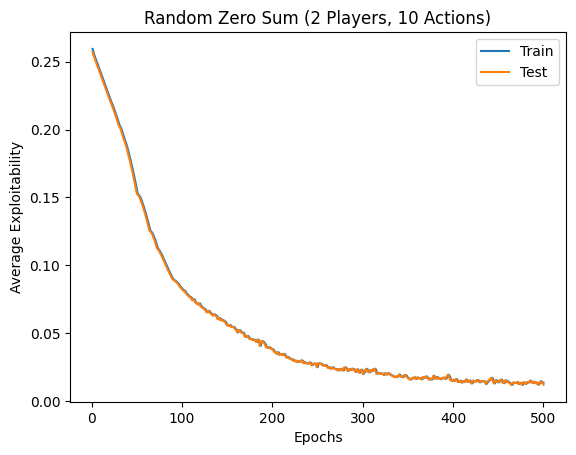

In [ ]:
init_data = jnp.expand_dims(rzs_data[0], 0)
train_data = jnp.expand_dims(rzs_data[0], 0)
test_data = jnp.expand_dims(rzs_data[0], 0)

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Random Zero Sum (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_rzs_loss_true_disc_2p_10a_graph.png")
files.download("gaes_rzs_loss_true_disc_2p_10a_graph.png")

### War of Attrition

Outer Training Epoch 50 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 150 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 250 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 350 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 450 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 550 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 650 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 750 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 850 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 950 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

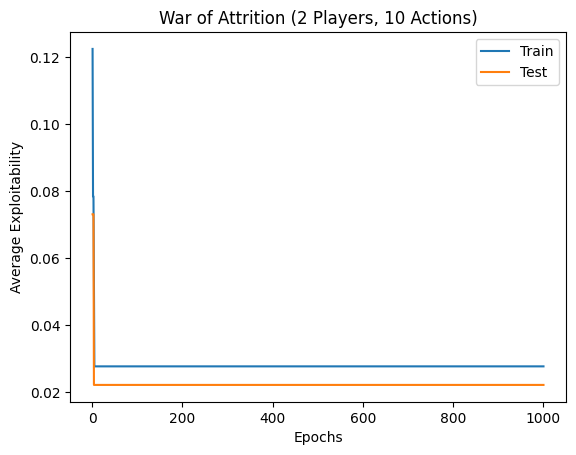

In [ ]:
init_data = woa_data[0]
train_data = jnp.vstack(woa_data[:1900])
test_data = jnp.vstack(woa_data[1900:])

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: Discriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-3),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("War of Attrition (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_woa_loss_true_disc_2p_10a_graph.png")
files.download("gaes_woa_loss_true_disc_2p_10a_graph.png")

### Dispersion Game

Outer Training Epoch 50 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 150 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 250 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 350 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 450 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 550 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 650 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 750 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 850 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 950 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

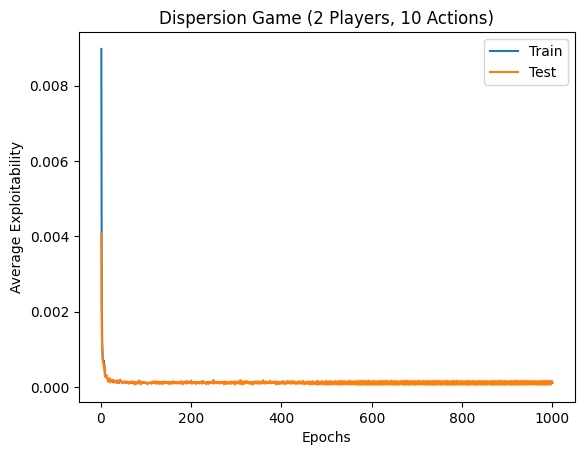

In [ ]:
init_data = dg_data[0]
train_data = jnp.vstack(dg_data[:1900])
test_data = jnp.vstack(dg_data[1900:])

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: Discriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-3),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Dispersion Game (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_dg_loss_true_disc_2p_10a_graph.png")
files.download("gaes_dg_loss_true_disc_2p_10a_graph.png")

### Travelers Dilemna

Outer Training Epoch 50 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 150 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 250 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 350 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 450 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 550 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 650 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 750 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 850 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 950 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

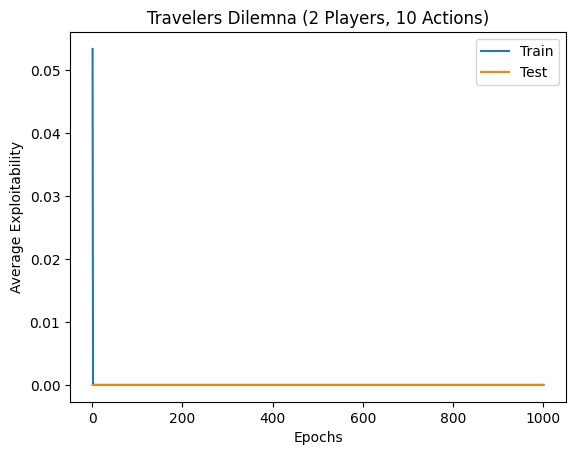

In [ ]:
init_data = td_data[0]
train_data = jnp.vstack(td_data[:1900])
test_data = jnp.vstack(td_data[1900:])

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: Discriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-3),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Travelers Dilemna (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_td_loss_true_disc_2p_10a_graph.png")
files.download("gaes_td_loss_true_disc_2p_10a_graph.png")

### Grab the Dollar

Outer Training Epoch 50 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 150 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 250 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 350 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 450 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 550 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 650 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 750 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 850 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 950 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

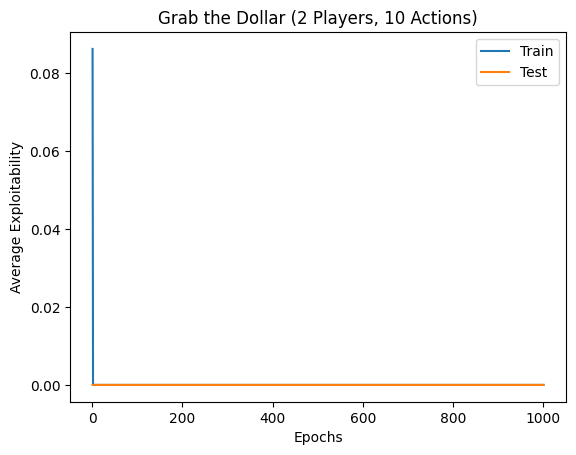

In [ ]:
init_data = gd_data[0]
train_data = jnp.vstack(gd_data[:1900])
test_data = jnp.vstack(gd_data[1900:])

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: Discriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-3),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Grab the Dollar (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_gd_loss_true_disc_2p_10a_graph.png")
files.download("gaes_gd_loss_true_disc_2p_10a_graph.png")

## Neural Network Discriminator


In [ ]:
# ALGO HYPERPARAMETERS

BATCH_SIZE = 1
GEN_EPOCHS = 1000
DISC_EPOCHS = 100

epochs_range = range(1, 1 + GEN_EPOCHS)

gen_lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6] # 1e-2 is way too large
disc_lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]

### Random Zero Sum

In [ ]:
init_data = jnp.expand_dims(rzs_data[0], 0)
train_data = jnp.expand_dims(rzs_data[0], 0)
test_data = jnp.expand_dims(rzs_data[0], 0)

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Random Zero Sum (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(5e-4),
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.figure()
plt.title("Random Zero Sum (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_rzs_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_rzs_loss_approx_disc_2p_10a_graph.png")

In [ ]:
# best tuples
best = [(5e-6, 1e-6), (5e-4, 1e-5)] # first one is a random walk, second is geometric brownian motion
best_2 = [(5e-6, 1e-5)] # lowest is 0.05.

### War of Attrition

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

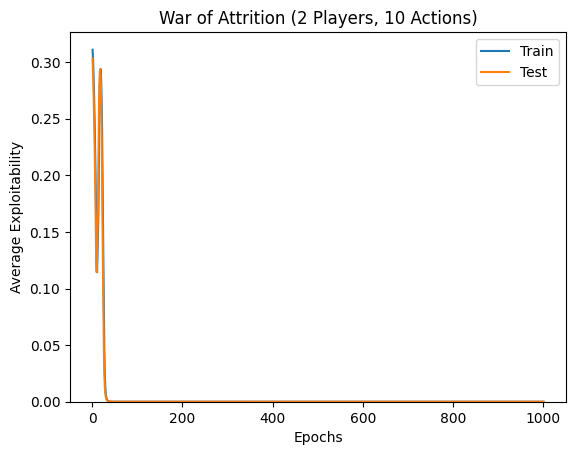

In [ ]:
init_data = jnp.expand_dims(woa_data[0], 0)
train_data = jnp.expand_dims(woa_data[0], 0)
test_data = jnp.expand_dims(woa_data[0], 0)

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"War of Attrition (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(5e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("War of Attrition (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_woa_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_woa_loss_approx_disc_2p_10a_graph.png")

In [ ]:
best = [(5e-5, 1e-5), (1e-4, 5e-4)]

### Dispersion Game

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

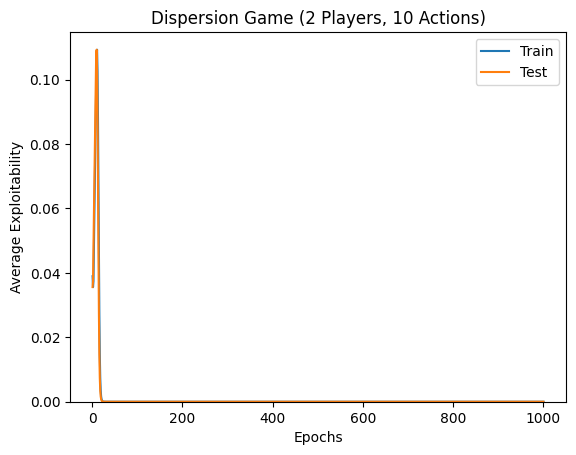

In [ ]:
init_data = jnp.expand_dims(dg_data[0], 0)
train_data = jnp.expand_dims(dg_data[0], 0)
test_data = jnp.expand_dims(dg_data[0], 0)

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Dispersion Game (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Dispersion Game (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_dg_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_dg_loss_approx_disc_2p_10a_graph.png")

In [ ]:
best = [(1e-4, 1e-3)] # has many but this is best

### Travelers Dilemna

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

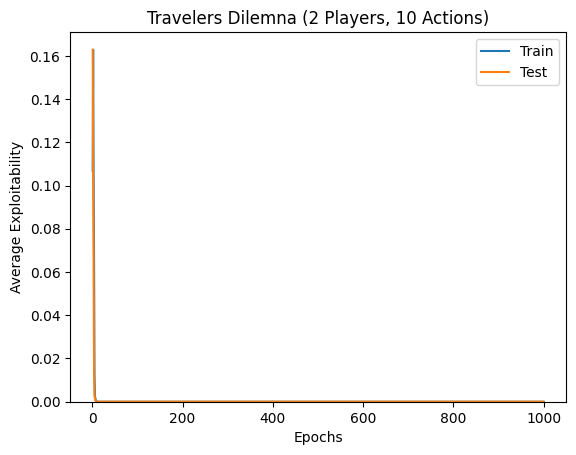

In [ ]:
init_data = jnp.expand_dims(td_data[0], 0)
train_data = jnp.expand_dims(td_data[0], 0)
test_data = jnp.expand_dims(td_data[0], 0)

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Travelers Dilemna (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-3),
                   optax.adam(1e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Travelers Dilemna (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_td_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_td_loss_approx_disc_2p_10a_graph.png")

In [ ]:
best = [(1e-3, 1e-4)] # many are great but this is best

### Grab the Dollar

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

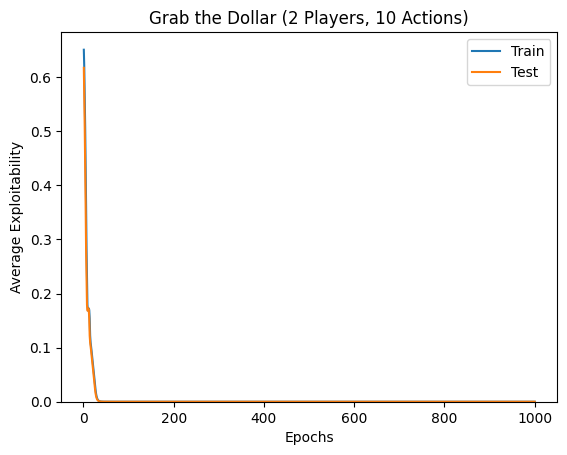

In [ ]:
init_data = jnp.expand_dims(gd_data[0], 0)
train_data = jnp.expand_dims(gd_data[0], 0)
test_data = jnp.expand_dims(gd_data[0], 0)

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Grab The Dollar (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(1e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Grab the Dollar (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_gd_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_gd_loss_approx_disc_2p_10a_graph.png")

In [ ]:
best = [(1e-4, 1e-4)]

### Rock, Paper, Scissors

In [ ]:
p1 = jnp.expand_dims(jnp.array([[0, 1.0, -1],
                [1, -1, 0],
                [-1, 0, 1]]), axis=0)
p2 = jnp.negative(p1)
data = jnp.expand_dims(jnp.concatenate([p1, p2], axis=0), axis=0)

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

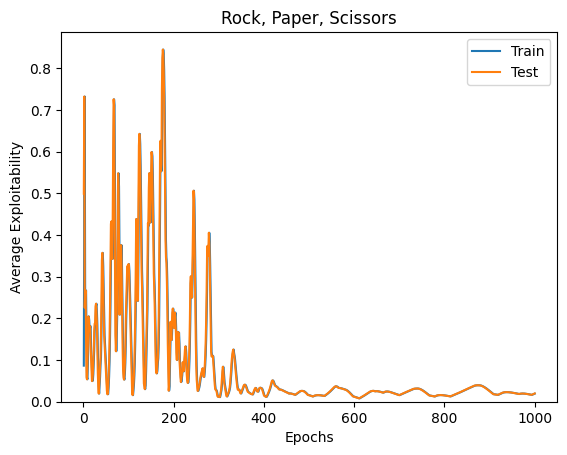

In [ ]:
init_data = data
train_data = data
test_data = data

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Rock Paper Scissors (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-3),
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Rock, Paper, Scissors")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_rps_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_rps_loss_approx_disc_2p_10a_graph.png")

In [ ]:
best = [(1e-3, 1e-5)]

### Hard Mixed Strategy Game

In [ ]:
p1 = jnp.expand_dims(jnp.array([[0, 1.0, 0],
                [0, 0, 1],
                [1, 0, 0]]), axis=0)
p2 = jnp.expand_dims(jnp.array([[0, 0, 1],
                [1, 0, 0],
                [0, 1.0, 0]]), axis=0)
data = jnp.expand_dims(jnp.concatenate([p1, p2], axis=0), axis=0)

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

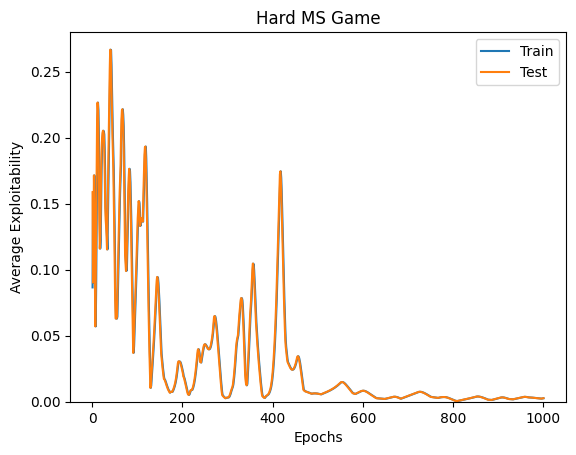

In [ ]:
init_data = data
train_data = data
test_data = data

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Hard Mixed Strategy Game (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Hard MS Game")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_hardms_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_hardms_loss_approx_disc_2p_10a_graph.png")

In [ ]:
best = [(5e-4, 5e-6), (1e-4, 1e-5), (5e-5, 5e-6), (5e-5, 5e-5), (5e-4, 5e-5)]

### Bertrand Oligopoly

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

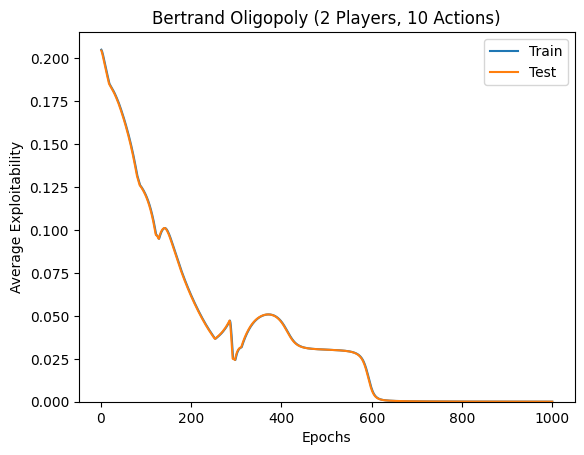

In [ ]:
init_data = jnp.expand_dims(bo_data[0], 0)
train_data = jnp.expand_dims(bo_data[0], 0)
test_data = jnp.expand_dims(bo_data[0], 0)

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Bertrand Oligopoly (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-5),
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Bertrand Oligopoly (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_bo_loss_approx_disc_2p_10a_graph.png")
files.download("gaes_bo_loss_approx_disc_2p_10a_graph.png")

In [ ]:
best = [(1e-5, 1e-5)] # wow so good

## Neural Network Discriminator (Bayes)

In [ ]:
# ALGO HYPERPARAMETERS

BATCH_SIZE = 50
GEN_EPOCHS = 1000
DISC_EPOCHS = 1

epochs_range = range(1, 1 + GEN_EPOCHS)

gen_lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6] # 1e-2 is way too large
disc_lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6]

### Random Zero Sum

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

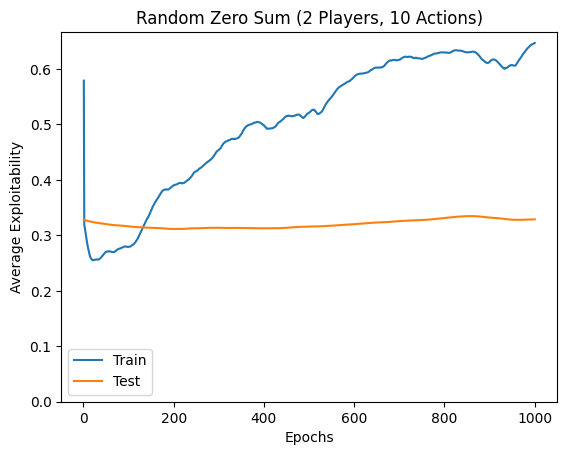

In [ ]:
init_data = jnp.expand_dims(rzs_data[0], 0)
train_data = rzs_data[1900:]
test_data = rzs_data[:1900]

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Random Zero Sum (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(5e-6),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.figure()
plt.title("Random Zero Sum (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("rzs_bayes.png")
files.download("rzs_bayes.png")

In [ ]:
best = [(5e-6, 1e-4)]

### War of Attrition

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

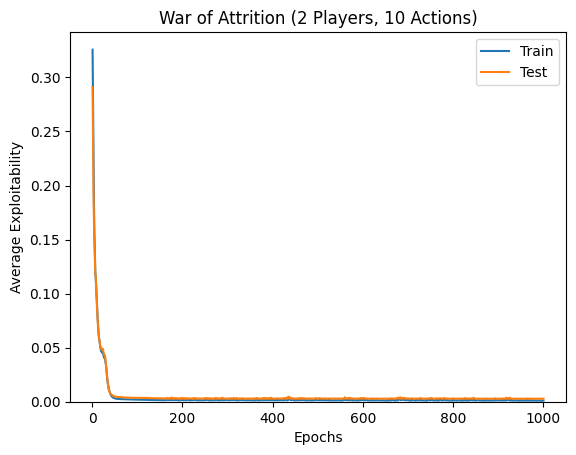

In [ ]:
init_data = jnp.expand_dims(woa_data[0], 0)
train_data = woa_data[1900:]
test_data = woa_data[:1900]

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: Generator_2()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"War of Attrition (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(5e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("War of Attrition (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("woa_bayes.png")
files.download("woa_bayes.png")

In [ ]:
works = [(1e-4, 5e-4)] # no batchnorm

### Dispersion Game

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

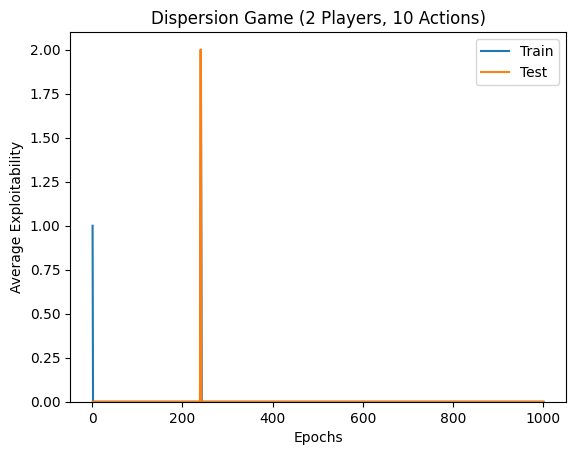

In [ ]:
init_data = jnp.expand_dims(dg_data[0], 0)
train_data = dg_data[1900:]
test_data = dg_data[:1900]

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Dispersion Game (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(1e-3),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Dispersion Game (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("dg_bayes.png")
files.download("dg_bayes.png")

In [ ]:
works = [(1e-4, 1e-3)] # works, no need to search

### Travelers Dilemna

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

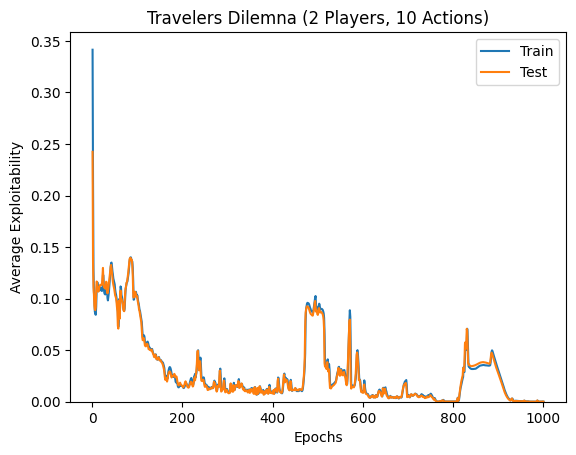

In [ ]:
init_data = jnp.expand_dims(td_data[0], 0)
train_data = td_data[1900:]
test_data = td_data[:1900]

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Travelers Dilemna (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(5e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Travelers Dilemna (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("td_bayes.png")
files.download("td_bayes.png")

In [ ]:
best = [(1e-4, 1e-4)] # no batchnorm
best = [(1e-3, 5e-5), (1e-4, 5e-5), (5e-5, 1e-4)] #batchnorm, used second one

###Grab the Dollar

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

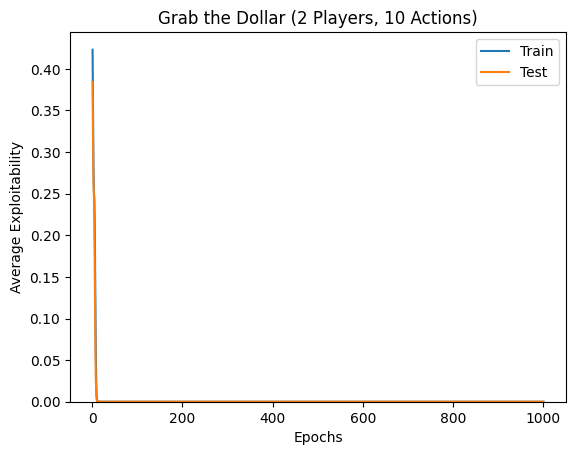

In [ ]:
init_data = jnp.expand_dims(gd_data[0], 0)
train_data = gd_data[1900:]
test_data = gd_data[:1900]

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGenerator()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Grab The Dollar (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: Discriminator_2()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-4),
                   optax.adam(1e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Grab the Dollar (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("gd_bayes.png")
files.download("gd_bayes.png")

In [ ]:
works = [(1e-4, 1e-4)] # works, no need for batchnorm

### Bertrand's Oligopoly

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

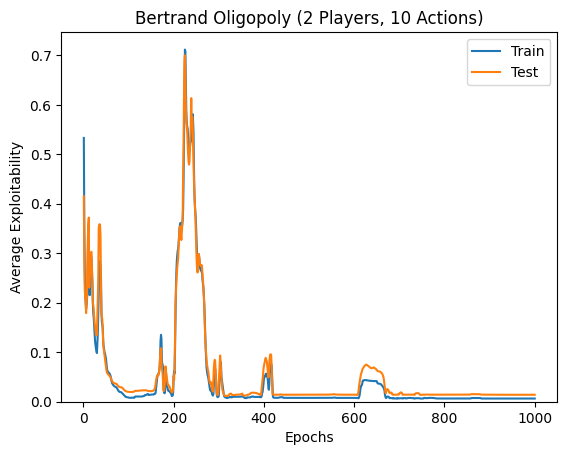

In [ ]:
init_data = jnp.expand_dims(bo_data[0], 0)
train_data = bo_data[1900:]
test_data = bo_data[:1900]

# for gen_lr in gen_lrs:
#   for disc_lr in disc_lrs:
#     SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
#     SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))
#     Test_GAES_1 = GAES(SimpleGen,
#                    SimpleDisc,
#                    optax.adam(gen_lr),
#                    optax.adam(disc_lr),
#                    distribution,
#                    regret_func)

#     Test_GAES_1.setup_custom_data(train_data, test_data)
#     gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(2), init_data)

#     gaes_state, log = Test_GAES_1.train(gaes_state,
#                                     GEN_EPOCHS,
#                                     DISC_EPOCHS,
#                                     BATCH_SIZE,
#                                     exploitability_func)

#     plt.figure()
#     plt.title(f"Bertrand Oligopoly (gen_lr={gen_lr}, disc_lr={disc_lr})")
#     plt.plot(epochs_range, log["train_exploitability"], label="Train")
#     plt.plot(epochs_range, log["test_exploitability"], label="Test")
#     plt.xlabel("Epochs")
#     plt.ylabel("Average Exploitability")
#     plt.legend(loc='best')

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: BayesGeneratorBN()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: DiscriminatorBN()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-3),
                   optax.adam(5e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), init_data)

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE,
                                    exploitability_func)

plt.title("Bertrand Oligopoly (2 Players, 10 Actions)")
plt.plot(epochs_range, log["train_exploitability"], label="Train")
plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.ylim(bottom=0)
plt.legend(loc='best')
# plt.show()
plt.savefig("bo_bayes.png")
files.download("bo_bayes.png")

In [ ]:
best = [(1e-4, 1e-3), (5e-5, 5e-5)] #no batchnorm, all stagnate and arent that good tbh
works = [(5e-5, 5e-5)] #w/ batchnorm works good enough tbh
best = [(1e-3, 5e-4), (1e-3, 1e-4), (5e-4, 1e-4)] # batchnorm, first one works

# Testing Exchange Economies

In [ ]:
class ExchangeGen(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, market_batch):
    # endowments.shape=(num_batch, num_players, num_goods)
    # valuations.shape=(num_batch, num_players, num_goods)
    endowments = market_batch["endowments"]
    valuations = market_batch["valuations"]
    rho = market_batch["rho"]
    num_batch, num_players, num_goods = jnp.shape(endowments)

    market = jnp.concatenate([valuations, endowments], axis=-1) # need to reshape?
    buyer_flat = jnp.reshape(market, (num_batch, num_players, num_goods * 2))
    mlp_1_1 = hk.Sequential([
        hk.Linear(20), jax.nn.relu,
        hk.Linear(10), jax.nn.relu
    ])
    latent_buyer_rep = mlp_1_1(buyer_flat)

    mlp_1_2 = hk.Sequential([
        hk.Linear(20), jax.nn.relu,
        hk.Linear(10), jax.nn.relu
    ])
    latent_valuation_rep = mlp_1_2(valuations)

    mlp_1_3 = hk.Sequential([
        hk.Linear(20), jax.nn.relu,
        hk.Linear(10), jax.nn.relu
    ])
    latent_endowment_rep = mlp_1_3(endowments)

    prod_valuation_endowment = jnp.multiply(latent_valuation_rep, latent_endowment_rep)

    substitution_rep = jnp.expand_dims(rho, axis=-1)
    mlp_1_4 = hk.Sequential([
        hk.Linear(20), jax.nn.relu,
        hk.Linear(10), jax.nn.relu
    ])
    latent_substitution_rep = mlp_1_4(substitution_rep)

    market_rep = jnp.concatenate(
        [
            latent_valuation_rep,
            latent_endowment_rep,
            prod_valuation_endowment,
            latent_substitution_rep, # included
            latent_buyer_rep
        ],
        axis=-1
        )
    mlp_2 = hk.Sequential([
        hk.Linear(20), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.relu
    ])
    latent_market_rep = mlp_2(market_rep) # shape=(num_batch, num_players, num_goods)

    good_graph = jnp.einsum("ijk,ijp->ikp", valuations, endowments) # shape=(num_batch, num_goods, num_goods)
    mlp_1_5 = hk.Sequential([
        hk.Linear(20), jax.nn.relu,
        hk.Linear(10), jax.nn.relu
    ])
    latent_good_graph = mlp_1_5(good_graph)

    num_batches = jnp.shape(endowments)[0]
    latent_market_rep = jnp.reshape(latent_market_rep, (num_batches, -1))
    latent_good_graph = jnp.reshape(latent_good_graph, (num_batches, -1))
    flattened_input = jnp.concatenate([latent_market_rep, latent_good_graph], axis=-1)
    mlp_3 = hk.Sequential([
        hk.Linear(40), jax.nn.relu,
        hk.Linear(20), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.softmax
    ])
    pred_prices = mlp_3(flattened_input) # shape=(num_batch, num_goods)
    pred_prices = jnp.clip(pred_prices, a_min=1**-8)

    tiled_prices = jnp.expand_dims(pred_prices, axis=1)
    tiled_prices = jnp.broadcast_to(tiled_prices, (num_batches, num_players, num_goods))
    # tiled_prices = jnp.repeat(jnp.expand_dims(pred_prices, axis=1), num_players, -1)

    # budget = jnp.einsum('ijk,ik->ij', endowments, pred_prices) # shape=(num_batch, num_players)
    mlp_4 = hk.Sequential([
        hk.Linear(30), jax.nn.relu,
        hk.Linear(20), jax.nn.relu
    ])
    latent_budget_rep = mlp_4(tiled_prices * endowments) # shape error here

    allocation_coefs = jnp.concatenate(
        [
            latent_buyer_rep,
            tiled_prices,
            latent_endowment_rep,
            latent_valuation_rep, # added
            jnp.divide(valuations, tiled_prices),
            jnp.multiply(valuations, tiled_prices),
            latent_substitution_rep,
            latent_budget_rep
        ],
        axis=-1
    )
    # modified
    mlp_5 = hk.Sequential([
        hk.Linear(50), jax.nn.relu,
        hk.Linear(20), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.softmax,
    ])
    allocation_coefs = mlp_5(allocation_coefs)

    # unsure if the 2 is hard-coded (no it refers to axis)
    budget_simplices = jnp.repeat(
            jnp.expand_dims((jnp.einsum("Bnm,Bm->Bn", endowments, pred_prices)),
                            axis=-1), num_goods, 2) / tiled_prices
    allocations = allocation_coefs * budget_simplices
    allocations = jnp.squeeze(allocations)
    allocations = jnp.clip(allocations, a_min=1e-8)
    return (allocations, pred_prices)

class ExchangeDisc(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, market_batch, gen_output):
    endowments = market_batch["endowments"]
    valuations = market_batch["valuations"]
    rho = market_batch["rho"]
    gen_allocations, gen_prices = gen_output
    num_batch, num_players, num_goods = jnp.shape(endowments)

    agg_demand = jnp.sum(gen_allocations, axis=1)
    agg_supply = jnp.sum(endowments, axis=1)
    agg_excess_demand = agg_demand - agg_supply
    response_prices = jnp.argmax(agg_excess_demand, axis=1)
    response_prices = jax.nn.one_hot(response_prices, num_goods)

    # tiled_prices = jnp.repeat(jnp.expand_dims(gen_prices, axis=1), num_players, -1)
    tiled_prices = jnp.expand_dims(gen_prices, axis=1)
    tiled_prices = jnp.broadcast_to(tiled_prices, (num_batch, num_players, num_goods))
    budget_simplices = jnp.repeat(
            jnp.expand_dims((jnp.einsum("Bnm,Bm->Bn", endowments, gen_prices)),
                            axis=-1), num_goods, 2) / tiled_prices

    mlp = hk.Sequential([
        hk.Linear(100), jax.nn.relu,
        hk.Linear(50), jax.nn.relu,
        hk.Linear(20), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.softmax,
    ])
    # different latent consumer reps depending on economy type
    # hard coding for Linear and Cobb-Douglass
    latent_consumer = jnp.divide(valuations, tiled_prices) # should be correct
    latent_consumer = mlp(latent_consumer)

    # response_allocations = jnp.sum(latent_consumer * budget_simplices, axis=1)
    response_allocations = latent_consumer * budget_simplices

    return (response_allocations, response_prices)

NUM_BUYERS = 5
NUM_GOODS = 10
UTIL_TYPE = "linear"

def distribution(rng, num_samples, params={}):
  # hard code number of buyers and goods
  num_buyers = NUM_BUYERS
  num_goods = NUM_GOODS
  subst_range = 0.0
  val_key, endow_key, rho_key = jax.random.split(rng, 3)
  valuations = jax.random.uniform(
      val_key,
      shape=(num_samples, num_buyers, num_goods),
      minval=1e-8,
      maxval=1.0)
  endowments = jax.random.uniform(
      endow_key,
      shape=(num_samples, num_buyers, num_goods),
      minval=1e-8,
      maxval=1.0)

  if subst_range == 0.0:
      rho_1 = jax.random.uniform(
          rho_key,
          shape=(int(num_samples / 2), num_buyers),
          minval=(0.5 - 0.25),
          maxval=(0.5 + 0.25))
      rho_2 = jax.random.uniform(
          rho_key,
          shape=(int(num_samples / 2), num_buyers),
          minval=(-1 - 0.25),
          maxval=(-1 + 0.25))
      rho = jnp.append(rho_1, rho_2, axis=0)
      assert rho.shape[0] == num_samples
  else:
      rho = jax.random.uniform(
          rho_key,
          shape=(num_samples, num_buyers),
          minval=(subst_range - 0.25),
          maxval=(subst_range + 0.25))

  market_batch = {
      "valuations": valuations,
      "endowments": endowments,
      "rho": rho
  }

  return market_batch

def buyer_utility_func(gen_disc_output, market_batch):
  allocations, prices = gen_disc_output
  allocations = jnp.clip(allocations, a_min=1e-8)
  prices = jnp.clip(prices, a_min=1e-8)
  endowments = jnp.clip(market_batch["endowments"], a_min=1e-8)
  valuations = jnp.clip(market_batch["valuations"], a_min=1e-8)
  rho = market_batch["rho"]
  util_type = UTIL_TYPE

  if util_type == "linear":
    def get_utils(allocs):
      return jnp.sum(jnp.multiply(allocs, valuations), axis=2) # preserves number of players? yes
  elif util_type == "leontief":
    def get_utils(allocs):
      return jnp.min((allocs / valuations), axis=2)
  elif util_type == "cd":
    valuations = (valuations.T / jnp.sum(valuations, axis=2)).T # doesnt work
    def get_utils(allocs):
      return jnp.prod(jnp.power(allocs, valuations), axis=2)
  elif util_type == "ces":
    def get_utils(allocs):
      return jnp.power(
            jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=2), (1 / rho))

  return get_utils(allocations)

@jax.jit
def regret_func(actions, responses, batch): # actually cumulative regret
  equilibrium_allocations, equilibrium_prices = actions
  response_allocations, response_prices = responses
  endowments = batch["endowments"]
  buyers = jnp.array([b for b in range(NUM_BUYERS)])
  buyers = jnp.reshape(buyers, (NUM_BUYERS, 1))

  def response_buyer_util(buyer_index):
    curr_response_allocations = jnp.copy(equilibrium_allocations)
    curr_response_allocations = curr_response_allocations.at[:, buyer_index].set(response_allocations[:, buyer_index]) # shapes not matching
    response_util = buyer_utility_func((curr_response_allocations, equilibrium_prices), batch)
    return response_util[:, buyer_index] # shape=(num_batches, 1)

  # add a seller's regret? (no for now)
  # seller_equilbrium_util = equilibrium_prices * (jnp.sum(equilibrium_allocations, axis=1)
  #                                                 - jnp.sum(endowments, axis=1))
  # seller_equilbrium_util = jnp.sum(seller_equilbrium_util, axis = 1)
  # seller_equilbrium_util = jnp.mean(seller_equilbrium_util)
  # seller_response_util = response_prices * (jnp.sum(response_allocations, axis=1)
  #                                                 - jnp.sum(endowments, axis=1))
  # seller_response_util = jnp.sum(seller_response_util, axis = 1)
  # seller_response_util = jnp.mean(seller_response_util)
  # seller_regret = seller_response_util - seller_equilbrium_util

  # # Might actually be stupid and it was this the whole time
  # equilibrium_util = jnp.sum(buyer_utility_func(actions, batch), axis=1)
  # response_util = jnp.sum(buyer_utility_func(responses, batch), axis=1)
  # cumulative_regret = jnp.mean(response_util - equilibrium_util) + seller_regret



  equilibrium_util = jnp.sum(buyer_utility_func(actions, batch), axis=1)
  response_util = jax.vmap(response_buyer_util, in_axes=[0])(buyers)
  response_util = jnp.sum(response_util, axis=0)
  cumulative_regret = jnp.mean(response_util - equilibrium_util) #+ seller_regret
  return cumulative_regret


In [ ]:
def get_linear_indirect_util(prices, budget, valuations):
  return jnp.max(valuations/prices)*budget

In [ ]:
def exploitability_func(pred_equilibrium, market):
  """Computes exploitability of allocations and prices for market.
  Args:
    allocations: Allocations of goods to traders
    prices: Prices of goods
    market: An Arrow-Debreu market jnp.ndarray[endowments, valuations]
  Returns:
    Exploitability associated with input allocations, prices, in the inputted
    market.
  """
  def single_game_exploitability(game_allocations, game_prices, game_endowments, game_valuations, game_rho):
    game_endowments = jnp.clip(game_endowments, a_min=1e-8)
    game_valuations = jnp.clip(game_valuations, a_min=1e-8)
    game_allocations = jnp.clip(game_allocations, a_min=1e-8)
    game_prices = jnp.clip(game_prices, a_min=1e-8)
    util_type = UTIL_TYPE
    if util_type == "linear":
      def get_utils(allocs):
        return jnp.sum(jnp.multiply(allocs, game_valuations), axis=1)

      def get_indirect_util(p, b, v, g_rho):
        _ = g_rho
        return get_linear_indirect_util(p, b, v)
    get_indirect_utils = jax.vmap(get_indirect_util, in_axes=[None, 0, 0, 0]) # does so for each player

    return jnp.max(jnp.sum(game_allocations, axis=0) - jnp.sum(
        game_endowments, axis=0)) - game_prices.T @ (jnp.sum(
            game_allocations, axis=0) - jnp.sum(game_endowments, axis=0)) + jnp.sum(
                (get_indirect_utils(game_prices, game_endowments @ game_prices, game_valuations,
                                    game_rho) - get_utils(game_allocations)))

  # shape=(num_batches, num_players, num_goods)
  allocations, prices = pred_equilibrium
  endowments = market["endowments"]
  valuations = market["valuations"]
  # shape=(num_batches, num_players)
  rho = market["rho"]
  tot_exploitability = jax.vmap(single_game_exploitability, in_axes=[0, 0, 0, 0, 0])(allocations, prices, endowments, valuations, rho)

  return jnp.mean(tot_exploitability)


In [ ]:
def random_action_func(rand_num, market):
  # buy random amount of good
  # prices set randomly
  key = jax.random.PRNGKey(rand_num)
  subkey1, subkey2 = jax.random.split(key)
  endowments = market["endowments"]
  valuations = market["valuations"]
  rho = market["rho"]

  num_buyers = jnp.shape(endowments)[1]
  num_goods = jnp.shape(endowments)[2]

  prices = jax.random.uniform(subkey1, shape=(1, num_goods))

  total_endowments = jnp.sum(endowments, axis=[0,1]) #shape=(num_goods)
  allocations = jax.random.uniform(subkey2, shape=(1, num_buyers, num_goods))
  good_sums = jnp.sum(allocations, axis=[0,1])
  allocations = allocations / good_sums
  allocations = allocations * total_endowments

  return (allocations, prices)

# def distribution(rng, num_samples, params={}):
#   # hard code number of buyers and goods
#   num_buyers = NUM_BUYERS
#   num_goods = NUM_GOODS
#   subst_range = 0.0
#   val_key, endow_key, rho_key = jax.random.split(rng, 3)
#   valuations = jax.random.uniform(
#       val_key,
#       shape=(num_samples, num_buyers, num_goods),
#       minval=1e-8,
#       maxval=1.0)
#   endowments = jax.random.uniform(
#       endow_key,
#       shape=(num_samples, num_buyers, num_goods),
#       minval=1e-8,
#       maxval=1.0)

#   if subst_range == 0.0:
#       rho_1 = jax.random.uniform(
#           rho_key,
#           shape=(int(num_samples / 2), num_buyers),
#           minval=(0.5 - 0.25),
#           maxval=(0.5 + 0.25))
#       rho_2 = jax.random.uniform(
#           rho_key,
#           shape=(int(num_samples / 2), num_buyers),
#           minval=(-1 - 0.25),
#           maxval=(-1 + 0.25))
#       rho = jnp.append(rho_1, rho_2, axis=0)
#       assert rho.shape[0] == num_samples
#   else:
#       rho = jax.random.uniform(
#           rho_key,
#           shape=(num_samples, num_buyers),
#           minval=(subst_range - 0.25),
#           maxval=(subst_range + 0.25))

#   market_batch = {
#       "valuations": valuations,
#       "endowments": endowments,
#       "rho": rho
#   }

#   return market_batch

Pretrain iter 1000 Completed
Pretrain iter 2000 Completed
Pretrain iter 3000 Completed
Pretrain iter 4000 Completed
Pretrain iter 5000 Completed
Pretrain iter 6000 Completed
Pretrain iter 7000 Completed
Pretrain iter 8000 Completed
Pretrain iter 9000 Completed
Pretrain iter 10000 Completed
Outer Training Epoch 50 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 150 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 250 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 350 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 450 Completed
Outer Training Epoch 500 Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

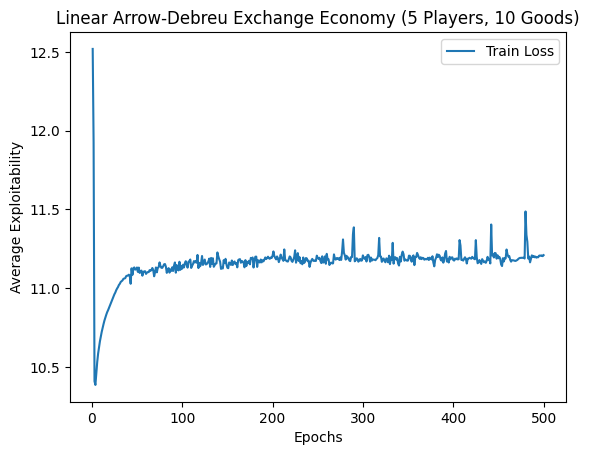

In [ ]:
Generator = hk.without_apply_rng(hk.transform(lambda *args: ExchangeGen()(*args)))
Discriminator = hk.without_apply_rng(hk.transform(lambda *args: ExchangeDisc()(*args)))

Solver = GAES(Generator,
              Discriminator,
              optax.adam(1e-3),
              optax.adam(1e-3), # increase lr to 1e-3, also increase epochs
              distribution,
              regret_func)

train_data, test_data = Solver.init_data(jax.random.PRNGKey(0), 900, 100, {}, {})
# print(jnp.shape(train_data["valuations"])) # valid
gaes_state = Solver.init_state(jax.random.PRNGKey(0), distribution(jax.random.PRNGKey(0), 8))

first_test_sample = {
    "valuations": test_data["valuations"][0],
    "endowments": test_data["endowments"][0],
    "rho": test_data["rho"][0]
}

gaes_state = Solver.pretrain_discriminator(jax.random.PRNGKey(42), 10000, random_action_func, gaes_state)

GEN_EPOCHS = 500 # increase epochs to ___, try warming up discriminator as well
gaes_state, log = Solver.train(gaes_state, GEN_EPOCHS, 1, 8, exploitability_func=exploitability_func)

plt.title("Linear Arrow-Debreu Exchange Economy (5 Players, 10 Goods)")
plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_excon_loss_graph.png")
files.download("gaes_excon_loss_graph.png")

# Can add an option to visualize testing loss as well

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

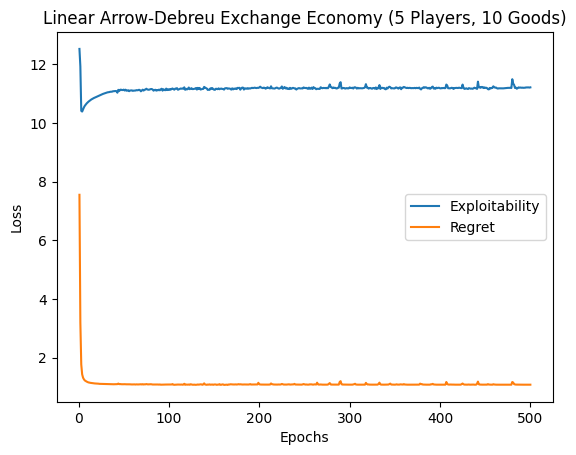

In [ ]:
plt.title("Linear Arrow-Debreu Exchange Economy (5 Players, 10 Goods)")
plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Exploitability")
plt.plot(range(1, GEN_EPOCHS + 1), log["gen_loss"], label="Regret")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()
plt.savefig("gaes_excon_regret_exploit_graph.png")
files.download("gaes_excon_regret_exploit_graph.png")

#Library Limitations

In [ ]:
# The return type of the generator and discriminator can be anything

# The batch structure must be that of a jnp.array or dictionary
  # In both cases, the first axes must always be the batch number.

# The user-inputted distribution function and exploitability function must adhere
# to JAX standards.
  # This means strictly following proper flow control.

# The purpose of returning the train and test data in init_data() is for data
# quality control and for personal testing afterwards

# The generator and discriminator must be transformed before being inputted to
# the GAES.
  # Examples will be shown (Normal Form Games and Exchange Economy)

# Auctions

## No Budget Constraints (2 Players)

In [ ]:
class BaseGenModel(hk.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layers = [
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1), jax.nn.sigmoid,
    ]

  def __call__(self, x, is_training=False):
    for layer in self.layers:
      if isinstance(layer, hk.BatchNorm):
        x = layer(x, is_training=is_training)
      else:
        x = layer(x)
    return x

class DisconnectedGenerator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, is_training=False):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of valuations. Shape is
        (num_batches, 2)
    Returns:
      bids: A jnp.array of bids. Shape is
        (num_batches, 2)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    # network = hk.Sequential([
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1), jax.nn.sigmoid,
    # ])
    model = BaseGenModel()

    p1_action = jnp.reshape(
        model(jnp.reshape(batch[:, 0], (num_batches, 1)), is_training=is_training),
        (num_batches, 1)
    )
    p2_action = jnp.reshape(
        model(jnp.reshape(batch[:, 1], (num_batches, 1)), is_training=is_training),
        (num_batches, 1)
    )

    action_profile = jnp.concatenate((p1_action, p2_action), axis=1)

    return action_profile

class ExAnteNashGenerator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, *args, **kwargs):
    return batch / 2.0

class FixedGenerator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, is_training=False):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of valuations. Shape is
        (num_batches, 2)
    Returns:
      bids: A jnp.array of bids. Shape is
        (num_batches, 2)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    # network = hk.Sequential([
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.relu,
    #     hk.Linear(1), jax.nn.sigmoid
    # ])
    # model = BaseGenModel()
    x_1 = jnp.reshape(batch[:, 0], (num_batches, 1))
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training=is_training)
    x_1 = jax.nn.relu(x_1)
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training=is_training)
    x_1 = jax.nn.relu(x_1)
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training=is_training)
    x_1 = jax.nn.relu(x_1)
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training=is_training)
    x_1 = jax.nn.relu(x_1)
    x_1 = hk.Linear(1)(x_1)
    x_1 = jax.nn.sigmoid(x_1)
    x_1 = jnp.reshape(x_1, (num_batches, 1))

    # x_1 = jnp.reshape(
    #     model(jnp.reshape(batch[:, 0], (num_batches, 1)), is_training=is_training),
    #     (num_batches, 1)
    # )
    x_2 = jnp.reshape(batch[:, 1], (num_batches, 1)) / 2.0
    bids = jnp.concatenate((x_1, x_2), axis=1)

    return bids

In [ ]:
class BaseDiscModel(hk.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layers = [
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
        hk.Linear(1), jax.nn.sigmoid,
    ]

  def __call__(self, x, is_training=False):
    for layer in self.layers:
      if isinstance(layer, hk.BatchNorm):
        x = layer(x, is_training=is_training)
      else:
        x = layer(x)
    return x

class ConnectedDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, bids, is_training=False):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of valuations. Shape is
        (num_batches, 2)
      bids: A jnp.array of bids. Shape is (num_batches, 2)
    Returns:
      response: A jnp.array of best response bids. Shape is
        (num_batches, 2)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    # Shouldn't matter too much since P(tie)=0
    # no need to softmax here bc no gradient descent on input
    # alloc_inds = jnp.argmax(bids, axis=1) # tie breaking rule=(player 1 always wins if tie)
    # allocation = jax.nn.one_hot(alloc_inds, 2) #shape=(num_batches, 2)
    allocation = inflated_softmax(bids, 10000)
    valuations = batch
    utils = allocation * (valuations - bids)
    payments = allocation * bids

    x = jnp.concatenate((bids, utils, allocation, valuations, payments), axis=1)
    x = jnp.reshape(x, (num_batches, -1))
    # x = jnp.concatenate((bids, allocation, allocation), axis=1)

    # changed number of hidden layer nodes
    x = jnp.reshape(x, (num_batches, -1))
    x = hk.Linear(1024)(x)
    x = hk.BatchNorm(True, True, 0.99)(x, is_training)
    x = jax.nn.softplus(x)
    x = hk.Linear(1024)(x)
    x = hk.BatchNorm(True, True, 0.99)(x, is_training)
    x = jax.nn.softplus(x)
    x = hk.Linear(1024)(x)
    x = hk.BatchNorm(True, True, 0.99)(x, is_training)
    x = jax.nn.softplus(x)
    x = hk.Linear(1024)(x)
    x = hk.BatchNorm(True, True, 0.99)(x, is_training)
    x = jax.nn.softplus(x)

    x = hk.Linear(2)(x)
    x = jax.nn.sigmoid(x)
    x = jnp.reshape(x, (num_batches, 2))

    return x

class FixedDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, bids, is_training=False):
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    x_1 = jnp.reshape(batch[:, 0], (num_batches, 1))
    x_1 = jnp.reshape(x_1, (num_batches, -1))
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training)
    x_1 = jax.nn.relu(x_1)
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training)
    x_1 = jax.nn.relu(x_1)
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training)
    x_1 = jax.nn.relu(x_1)
    x_1 = hk.Linear(1024)(x_1)
    x_1 = hk.BatchNorm(True, True, 0.99)(x_1, is_training)
    x_1 = jax.nn.relu(x_1)

    x_1 = hk.Linear(1)(x_1)
    x_1 = jax.nn.sigmoid(x_1)
    x_1 = jnp.reshape(x_1, (num_batches, 1))

    x_2 = batch[:, 1] / 2.0
    x_2 = jnp.reshape(x_2, (num_batches, 1))

    best_response_bids = jnp.concatenate((x_1, x_2), axis=1)

    return best_response_bids

# # ex-post discriminator (finds best response bids ex-post)
class ExPostDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, bids, *args, **kwargs):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of valuations. Shape is
        (num_batches, 2)
      bids: A jnp.array of bids. Shape is (num_batches, 2)
    Returns:
      response: A jnp.array of best response bids. Shape is
        (num_batches, 2)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    # minimum of op bid + epislion and our valuation
    p1_new_bids = jnp.minimum(bids[:, 1] + 1e-3, batch[:, 0])
    p1_new_bids = jnp.reshape(p1_new_bids, (num_batches, 1))
    p2_new_bids = jnp.minimum(bids[:, 0] + 1e-3, batch[:, 1])
    p2_new_bids = jnp.reshape(p2_new_bids, (num_batches, 1))

    return jnp.concatenate((p1_new_bids, p2_new_bids), axis=1)

class ExAnteNashDiscriminator(hk.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, bids, *args, **kwargs):
    return batch / 2.0

class DisconnectedDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, bids, is_training=False):
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    allocation = inflated_softmax(bids, 10000)
    valuations = batch
    utils = allocation * (valuations - bids)
    payments = allocation * bids

    x_1 = jnp.hstack((jnp.reshape(valuations[:, 0], (num_batches, 1))))
    x_1 = jnp.reshape(x_1, (num_batches, -1))
    x_2 = jnp.hstack((jnp.reshape(valuations[:, 1], (num_batches, 1))))
    x_2 = jnp.reshape(x_2, (num_batches, -1))

    # network = hk.Sequential([
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1024), hk.BatchNorm(True, True, 0.99), jax.nn.softplus,
    #     hk.Linear(1), jax.nn.sigmoid,
    # ])
    model = BaseDiscModel()

    p1_response = jnp.reshape(model(x_1, is_training=is_training), (num_batches, 1))
    p2_response = jnp.reshape(model(x_2, is_training=is_training), (num_batches, 1))
    x = jnp.concatenate((p1_response, p2_response), axis=1)

    return x

In [ ]:
def distribution(rng, num_samples, params):
  return None

def regret_func(action, response, batch):
  # response = jnp.where(response <= 0, 1, response)
  # set_trace()

  valuations = batch
  # action = jax.nn.relu(action)
  # response = jax.nn.relu(response)
  # argmax may not be differentiable
  action_allocation = inflated_softmax(action, 10000) # shape=(num_batches, 2)
  action_util = action_allocation * (valuations - action)
  action_util = action_util - 0.05 # added

  x_1_new_bids = jnp.stack((response[:,0], action[:,1]), axis=-1)
  x_2_new_bids = jnp.stack((action[:,0], response[:,1]), axis=-1)
  x_1_alloc = inflated_softmax(x_1_new_bids, 10000) # need large scaling factor for small epsilon vals
  x_2_alloc = inflated_softmax(x_2_new_bids, 10000)
  x_1_util = x_1_alloc * (valuations - x_1_new_bids)
  x_2_util = x_2_alloc * (valuations - x_2_new_bids)
  response_util = jnp.stack((x_1_util[:,0], x_2_util[:,1]), axis=-1)
  response_util = response_util - 0.05 # added

  regret = jnp.max(
      jnp.sum(
          response_util - action_util,
          axis=1
      )
  )

  return regret

In [ ]:
batch = jnp.array([[0.1, 0.3], [0.4, 0.5], [0.8, 0.7]])
actions = batch / 4.0
responses = batch / 3.0
print(regret_func(actions, responses, batch))

# batch_1 = jnp.array([[1/3, 2/3]])
# action_1 = jnp.array([[1/6, 1/2]])
# response_1 = jnp.array([[0, 1/3]])
# print(regret_func(action_1, response_1, batch_1))

0.39999992


### Disconnected Gen + Connected Disc



In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 100
DISC_EPOCHS = 1
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: ConnectedDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-5),
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

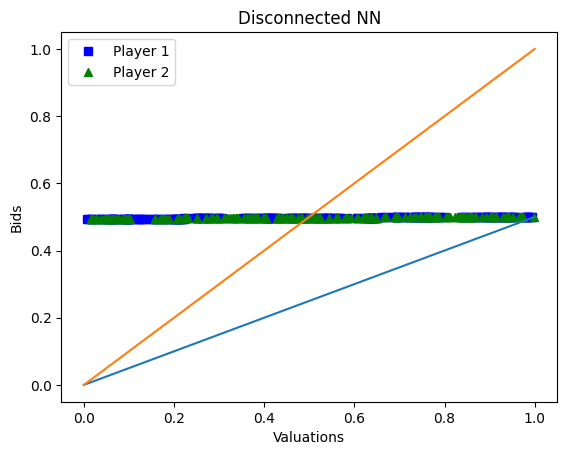

In [ ]:
NUM_TEST_SAMPLES = 200

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
p1_output = output[:, 0]
p2_output = output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Disconnected NN")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Bids")
plt.legend(["Player 1", "Player 2"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen+Disc.png")
# files.download("disconnectedGen+Disc.png")

In [ ]:
# print(input[:10])
print(output[:10])
print(SimpleDisc.apply(gaes_state.params.disc, input, output)[:10])

[[0.50000054 0.49868786]
 [0.49528357 0.49855673]
 [0.5006661  0.5003771 ]
 [0.4974854  0.4990649 ]
 [0.49695325 0.49960062]
 [0.5001548  0.4960915 ]
 [0.4951297  0.49633643]
 [0.49901524 0.5005092 ]
 [0.4950181  0.49837464]
 [0.5006352  0.4960687 ]]
[[0.49950397 0.5007026 ]
 [0.4850344  0.4960536 ]
 [0.5012771  0.5015751 ]
 [0.49975413 0.49829116]
 [0.4980554  0.4977945 ]
 [0.4969102  0.48868138]
 [0.47743472 0.48411405]
 [0.5013881  0.4999467 ]
 [0.4831868  0.4957874 ]
 [0.496898   0.4893268 ]]


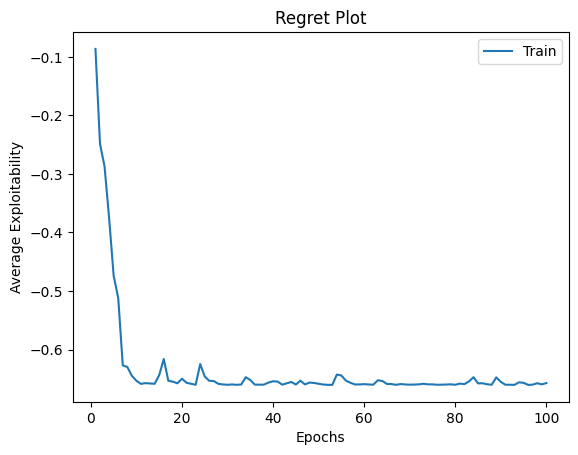

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen_Disc_Regret.png")
# files.download("disconnectedGen_Disc_Regret.png")

### Disconnected Gen + Disconnected Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 20000 # should take 7 hours to train
DISC_EPOCHS = 1
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.sgd(2 * 1e-5), # maybe change
                   optax.sgd(1e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed
Outer Training Epoch 1100 Completed
Outer Training Epoch 1200 Completed
Outer Training Epoch 1300 Completed
Outer Training Epoch 1400 Completed
Outer Training Epoch 1500 Completed
Outer Training Epoch 1600 Completed
Outer Training Epoch 1700 Completed
Outer Training Epoch 1800 Completed
Outer Training Epoch 1900 Completed
Outer Training Epoch 2000 Completed
Outer Training Epoch 2100 Completed
Outer Training Epoch 2200 Completed
Outer Training Epoch 2300 Completed
Outer Training Epoch 2400 Completed
Outer Training Epoch 2500 Completed
Outer Training Epoch 2600 Completed
Outer Training Epoch 2700 Completed
Oute

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

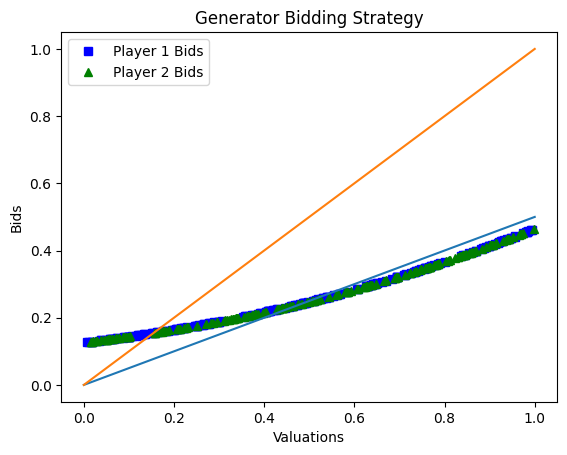

In [ ]:
NUM_TEST_SAMPLES = 200

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
p1_output = output[:, 0]
p2_output = output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Generator Bidding Strategy")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Bids")
plt.legend(["Player 1 Bids", "Player 2 Bids"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
plt.savefig("disconnectedGen+disconnectedDisc.png")
files.download("disconnectedGen+disconnectedDisc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

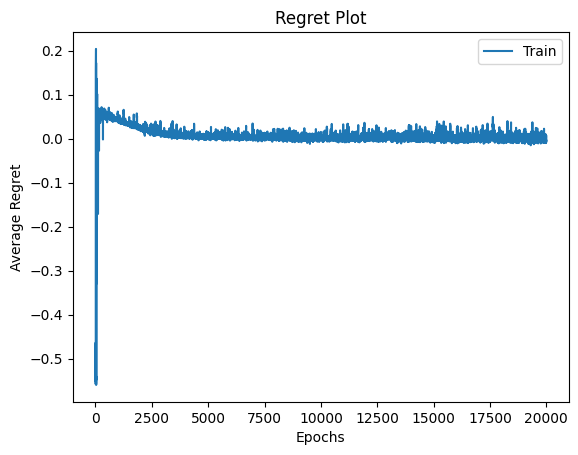

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Regret")
plt.legend(loc='best')
# plt.show()
plt.savefig("disconnectedGen+disconnectedDisc_Regret.png")
files.download("disconnectedGen+disconnectedDisc_Regret.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

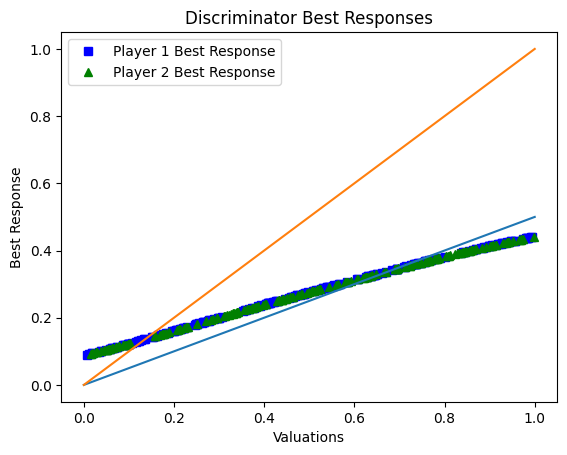

In [ ]:
NUM_TEST_SAMPLES = 200

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_output = disc_output[:, 0]
p2_output = disc_output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Discriminator Best Responses")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Best Response")
plt.legend(["Player 1 Best Response", "Player 2 Best Response"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
plt.savefig("disconnectedGen+disconnectedDisc_disc.png")
files.download("disconnectedGen+disconnectedDisc_disc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

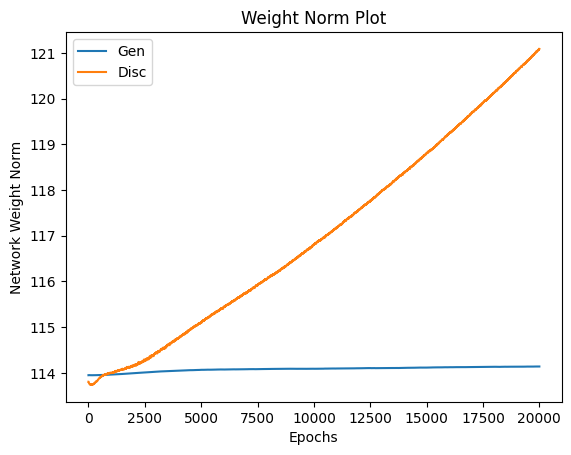

In [ ]:
plt.title("Weight Norm Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_weight_norm"], label="Gen")
plt.plot(range(1, GEN_EPOCHS+1), log["disc_weight_norm"], label="Disc")
plt.xlabel("Epochs")
plt.ylabel("Network Weight Norm")
plt.legend(loc='best')
# plt.show()
plt.savefig("disconnectedGen+disconnectedDisc_Weights.png")
files.download("disconnectedGen+disconnectedDisc_Weights.png")

### Ex-Ante Nash Gen + Disconnected Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 100
DISC_EPOCHS = 1
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: ExAnteNashGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-5), # maybe change
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed


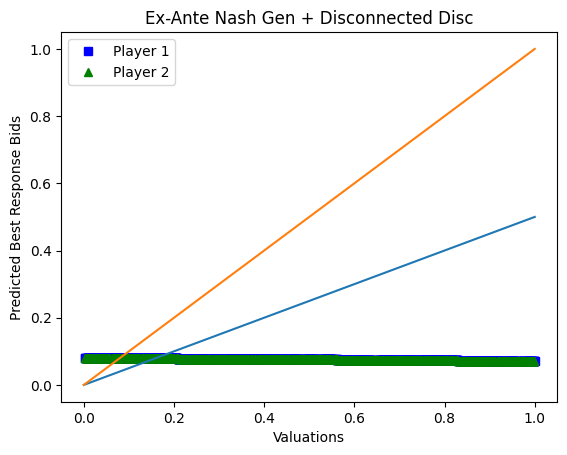

In [ ]:
NUM_TEST_SAMPLES = 1000

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_output = disc_output[:, 0]
p2_output = disc_output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Ex-Ante Nash Gen + Disconnected Disc")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Predicted Best Response Bids")
plt.legend(["Player 1", "Player 2"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteNashGen+disconnectedDisc_some.png")
# files.download("exAnteNashGen+disconnectedDisc_some.png")

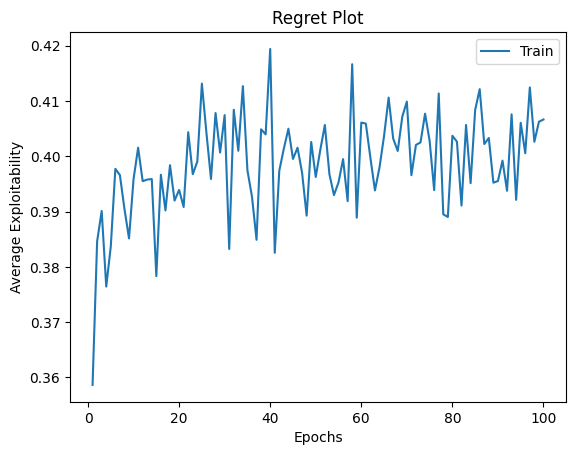

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteNashGen_disconnectedDisc_Regret_some.png")
# files.download("exAnteNashGen_disconnectedDisc_Regret_some.png")

### Disconnected Gen + Ex-Ante Nash Disc

In [ ]:
# Bayesian Discriminator

NUM_SAMPLES = 2000
GEN_EPOCHS = 10000
DISC_EPOCHS = 0
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: ExAnteNashDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(5 * 1e-5), # maybe change
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed


KeyboardInterrupt: 

In [ ]:
NUM_TEST_SAMPLES = 200

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
p1_output = output[:, 0]
p2_output = output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Discriminator Bids")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Bids")
plt.legend(["Player 1 Bids", "Player 2 Bids"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
plt.savefig("disconnectedGen+exAnteDisc.png")
files.download("disconnectedGen+exAnteDisc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

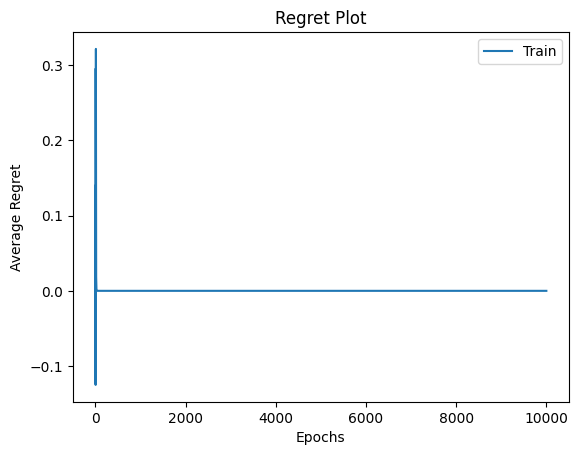

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Regret")
plt.legend(loc='best')
# plt.show()
plt.savefig("disconnectedGen+exAnteDisc_Regret.png")
files.download("disconnectedGen+exAnteDisc_Regret.png")

### Ex-Ante Nash Gen + Fixed Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 250
DISC_EPOCHS = 1
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: ExAnteNashGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: FixedDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.sgd(1e-4), # maybe change
                   optax.sgd(1e-4),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

TypeError: <lambda>() got an unexpected keyword argument 'is_training'

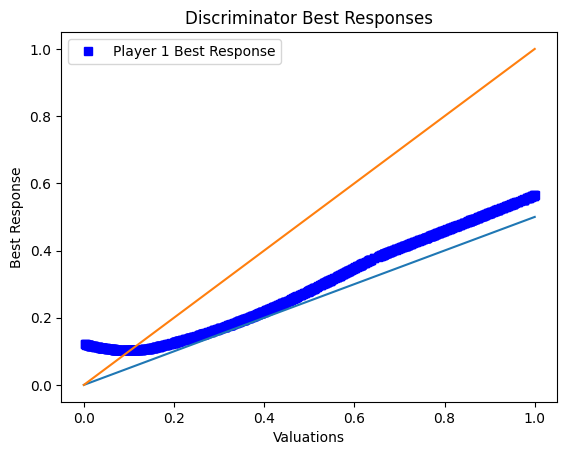

In [ ]:
# It's giving the ex-post best response,
# which is techncally correct if its given both player bids
# so its functioning properly

NUM_TEST_SAMPLES = 1000

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_output = disc_output[:, 0]
# p2_output = disc_output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
# plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Discriminator Best Responses")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Best Response")
plt.legend(["Player 1 Best Response"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteGen+fixedDisc.png")
# files.download("exAnteGen+fixedDisc.png")

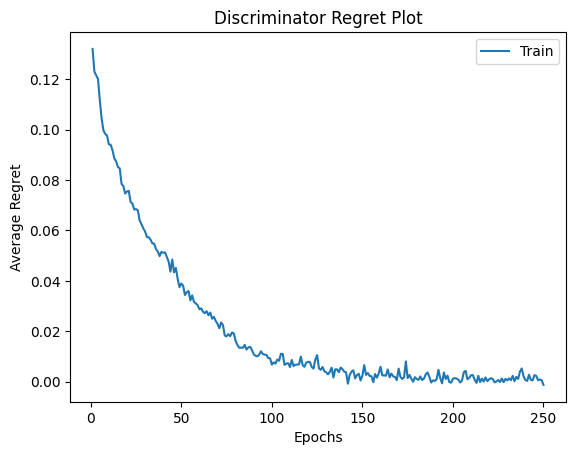

In [ ]:
plt.title("Discriminator Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), -log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Regret")
plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteGen+fixedDisc_Regret.png")
# files.download("exAnteGen+fixedDisc_Regret.png")

### Fixed Gen + Ex-Ante Nash Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 10000
DISC_EPOCHS = 0 # No need to train disc
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform_with_state(lambda *args: FixedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform_with_state(lambda *args: ExAnteNashDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.sgd(1e-4), # maybe change
                   optax.sgd(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

Outer Training Epoch 1 Completed


In [ ]:
def get_weights(params):
    weights = []
    for layer_params in params.values():
        for name, value in layer_params.items():
            if 'w' in name:
                weights.append(value)
    return weights

# Compute the sum of the norms of the weights
def sum_of_norms(weights):
    norms = [jnp.linalg.norm(weight) for weight in weights]
    return sum(norms)

weights_gen = get_weights(gaes_state.params.gen)
norm_gen = sum_of_norms(weights_gen)

weights_disc = get_weights(gaes_state.params.disc)
norm_disc = sum_of_norms(weights_disc)

print(norm_gen)
print(norm_disc)

114.27578
0


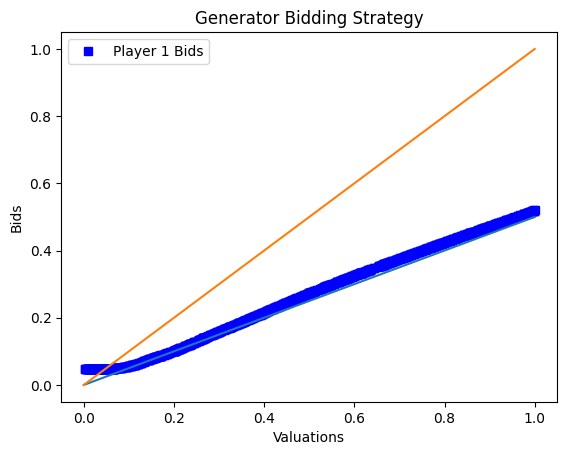

In [ ]:
NUM_TEST_SAMPLES = 1000

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_output = gen_output[:, 0] # oopsies
# p2_output = disc_output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
# plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Generator Bidding Strategy")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Bids")
plt.legend(["Player 1 Bids"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("fixedGen+exAnteDisc.png")
# files.download("fixedGen+exAnteDisc.png")

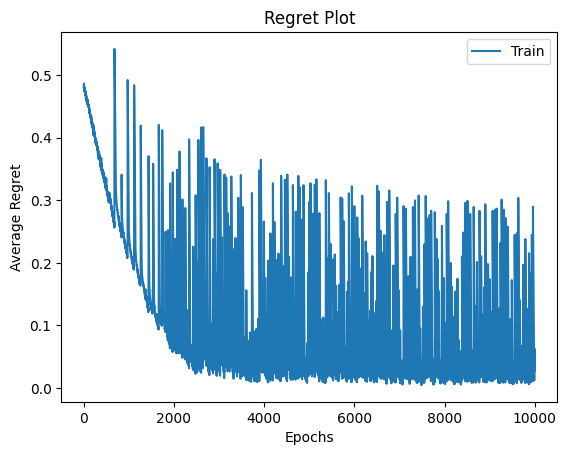

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Regret")
plt.legend(loc='best')
# plt.show()
# plt.savefig("fixedGen+exAnteDisc_Regret.png")
# files.download("fixedGen+exAnteDisc_Regret.png")

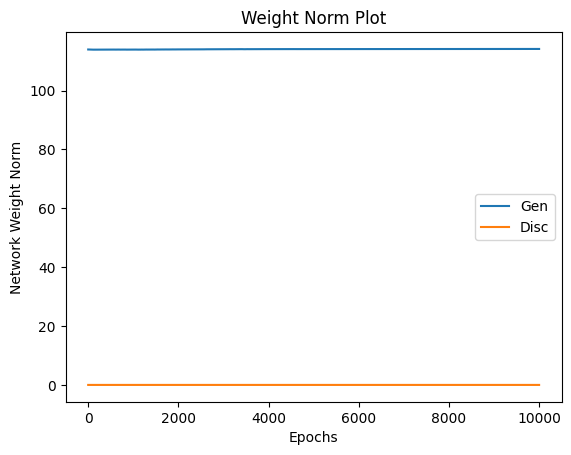

In [ ]:
plt.title("Weight Norm Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_weight_norm"], label="Gen")
plt.plot(range(1, GEN_EPOCHS+1), log["disc_weight_norm"], label="Disc")
plt.xlabel("Epochs")
plt.ylabel("Network Weight Norm")
plt.legend(loc='best')
# plt.show()
# plt.savefig("fixedGen+exAnteDisc_Regret.png")
# files.download("fixedGen+exAnteDisc_Regret.png")

### Fixed Gen + Fixed Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 100
DISC_EPOCHS = 1
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: FixedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: FixedDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-5), # maybe change
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

Outer Training Epoch 100 Completed


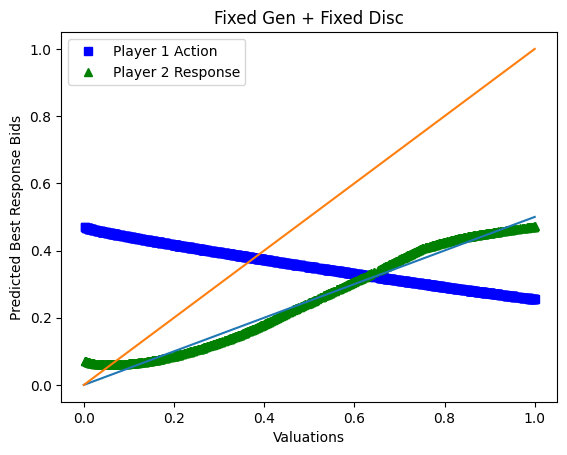

In [ ]:
# Currently plots disc output

NUM_TEST_SAMPLES = 1000

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_action = gen_output[:, 0]
p1_response = disc_output[:, 0]

plt.plot(p1_input, p1_action, 'bs')
plt.plot(p1_input, p1_response, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Fixed Gen + Fixed Disc")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Predicted Best Response Bids")
plt.legend(["Player 1 Action", "Player 2 Response"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteNashGen+disconnectedDisc_some.png")
# files.download("exAnteNashGen+disconnectedDisc_some.png")

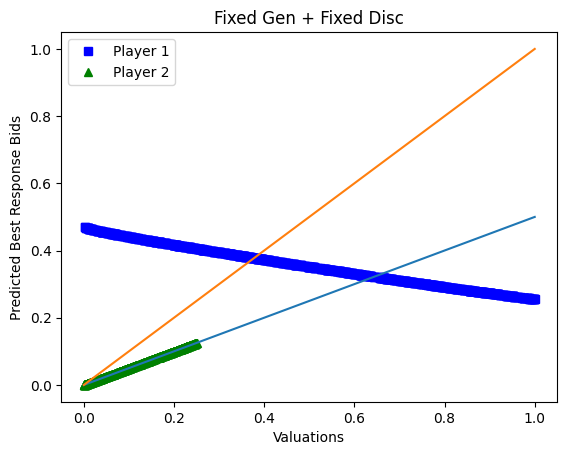

In [ ]:
# Conditional data
# p1 valuations always greater

NUM_TEST_SAMPLES = 1000

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = p1_input / 4.0
input = jnp.concatenate((p1_input, p2_input), axis=1)

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_output = gen_output[:, 0]
p2_output = gen_output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Fixed Gen + Fixed Disc")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Predicted Best Response Bids")
plt.legend(["Player 1", "Player 2"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteNashGen+disconnectedDisc_some.png")
# files.download("exAnteNashGen+disconnectedDisc_some.png")

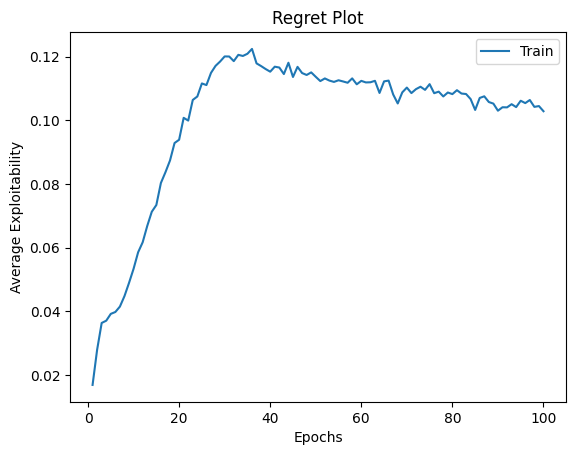

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteNashGen_disconnectedDisc_Regret_some.png")
# files.download("exAnteNashGen_disconnectedDisc_Regret_some.png")

### Disconnected Gen + Ex-Post Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 10000
DISC_EPOCHS = 0
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: ExPostDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(3 * 1e-5),
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

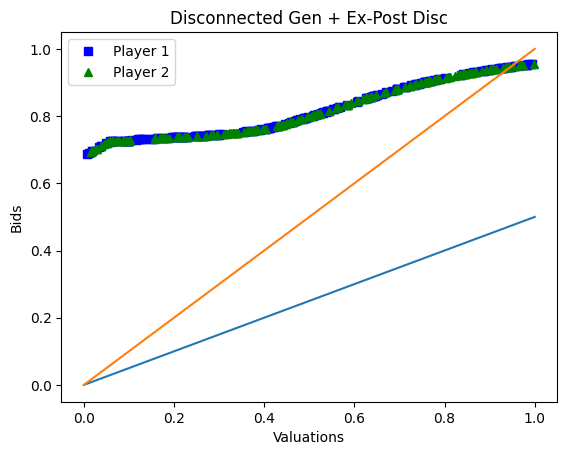

In [ ]:
NUM_TEST_SAMPLES = 200

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input), axis=1)

output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
p1_output = output[:, 0]
p2_output = output[:, 1]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Disconnected Gen + Ex-Post Disc")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Bids")
plt.legend(["Player 1", "Player 2"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen+Disc.png")
# files.download("disconnectedGen+Disc.png")

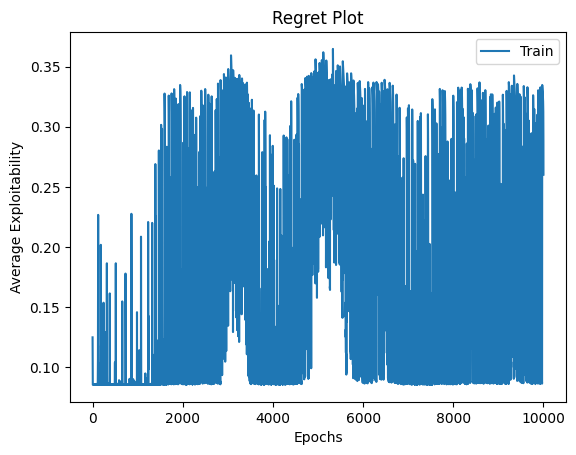

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen_Disc_Regret.png")
# files.download("disconnectedGen_Disc_Regret.png")

Text(0, 0.5, 'P2 Best-Response')

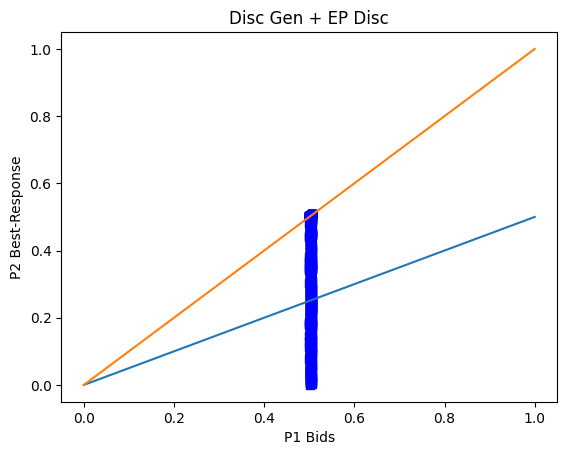

In [ ]:
# Conditional Plots
# P1 Bids vs P2 BR

NUM_TEST_SAMPLES = 1000

input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 2))

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_bids = gen_output[:, 0]
p2_br = disc_output[:, 1]

plt.plot(p1_bids, p2_br, 'bs')
plt.plot([0,1], [0,1/2])
plt.plot([0,1], [0,1])


plt.title("Disc Gen + EP Disc")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("P1 Bids")
plt.ylabel("P2 Best-Response")
# plt.legend(["Player 1", "Player 2"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("exAnteNashGen+disconnectedDisc_some.png")
# files.download("exAnteNashGen+disconnectedDisc_some.png")

In [ ]:
# Why is bid better than best response?
# print(regret_func(input, disc_output, input))
print(input[:5])
print(gen_output[:5])
print(disc_output[:5])
# regret_func(gen_output[:1], disc_output[:1], input[:1])

[[0.29347873 0.859866  ]
 [0.6342524  0.62999177]
 [0.08714521 0.0083952 ]
 [0.517442   0.63360596]
 [0.41464555 0.6491431 ]]
[[0.5023115  0.5056685 ]
 [0.50432736 0.5043185 ]
 [0.5010512  0.5006204 ]
 [0.50363356 0.5043236 ]
 [0.50302696 0.5044196 ]]
[[0.29347873 0.5033115 ]
 [0.50531846 0.50532734]
 [0.08714521 0.0083952 ]
 [0.5053236  0.50463355]
 [0.41464555 0.50402695]]


## No Budget Constraints (3 Players)

In [ ]:
class DisconnectedGenerator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of valuations. Shape is
        (num_batches, 2)
    Returns:
      bids: A jnp.array of bids. Shape is
        (num_batches, 2)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    network = hk.Sequential([
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1), jax.nn.sigmoid,
    ])

    p1_action = jnp.reshape(
        network(jnp.reshape(batch[:, 0], (num_batches, 1))),
        (num_batches, 1)
    )
    p2_action = jnp.reshape(
        network(jnp.reshape(batch[:, 1], (num_batches, 1))),
        (num_batches, 1)
    )
    p3_action = jnp.reshape(
        network(jnp.reshape(batch[:, 2], (num_batches, 1))),
        (num_batches, 1)
    )

    action_profile = jnp.concatenate((p1_action, p2_action, p3_action), axis=1)

    return action_profile

In [ ]:
class DisconnectedDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, bids):
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    x_1 = jnp.hstack((jnp.reshape(batch[:, 0], (num_batches, 1))))
    x_1 = jnp.reshape(x_1, (num_batches, -1))
    x_2 = jnp.hstack((jnp.reshape(batch[:, 1], (num_batches, 1))))
    x_2 = jnp.reshape(x_2, (num_batches, -1))
    x_3 = jnp.hstack((jnp.reshape(batch[:, 2], (num_batches, 1))))
    x_3 = jnp.reshape(x_3, (num_batches, -1))

    network = hk.Sequential([
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1), jax.nn.sigmoid,
    ])

    p1_response = jnp.reshape(network(x_1), (num_batches, 1))
    p2_response = jnp.reshape(network(x_2), (num_batches, 1))
    p3_response = jnp.reshape(network(x_3), (num_batches, 1))
    x = jnp.concatenate((p1_response, p2_response, p3_response), axis=1)

    return x

In [ ]:
def distribution(rng, num_samples, params):
  return None

def regret_func(action, response, batch):
  # set_trace()

  valuations = batch
  action_allocation = inflated_softmax(action, 10000) # shape=(num_batches, 2)
  action_util = action_allocation * (valuations - action)
  action_util = action_util - 0.05

  x_1_new_bids = jnp.stack((response[:,0], action[:,1], action[:,2]), axis=-1)
  x_2_new_bids = jnp.stack((action[:,0], response[:,1], action[:,2]), axis=-1)
  x_3_new_bids = jnp.stack((action[:,0], action[:,1], response[:,2]), axis=-1)
  x_1_alloc = inflated_softmax(x_1_new_bids, 10000) # need large scaling factor for small epsilon vals
  x_2_alloc = inflated_softmax(x_2_new_bids, 10000)
  x_3_alloc = inflated_softmax(x_3_new_bids, 10000)
  x_1_util = x_1_alloc * (valuations - x_1_new_bids)
  x_2_util = x_2_alloc * (valuations - x_2_new_bids)
  x_3_util = x_3_alloc * (valuations - x_3_new_bids)
  response_util = jnp.stack((x_1_util[:,0], x_2_util[:,1], x_3_util[:,2]), axis=-1)
  response_util = response_util - 0.05

  regret = jnp.mean(
      jnp.sum(
          response_util - action_util,
          axis=1
      )
  )

  return regret

### Disconnected Gen + Disconnected Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 20000
DISC_EPOCHS = 1
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 3))
data = valuations
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.sgd(6 * 1e-5), # maybe change
                   optax.sgd(6 * 1e-6),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
# print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])

gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed
Outer Training Epoch 1100 Completed
Outer Training Epoch 1200 Completed
Outer Training Epoch 1300 Completed
Outer Training Epoch 1400 Completed
Outer Training Epoch 1500 Completed
Outer Training Epoch 1600 Completed
Outer Training Epoch 1700 Completed
Outer Training Epoch 1800 Completed
Outer Training Epoch 1900 Completed
Outer Training Epoch 2000 Completed
Outer Training Epoch 2100 Completed
Outer Training Epoch 2200 Completed
Outer Training Epoch 2300 Completed
Outer Training Epoch 2400 Completed
Outer Training Epoch 2500 Completed
Outer Training Epoch 2600 Completed
Outer Training Epoch 2700 Completed
Oute

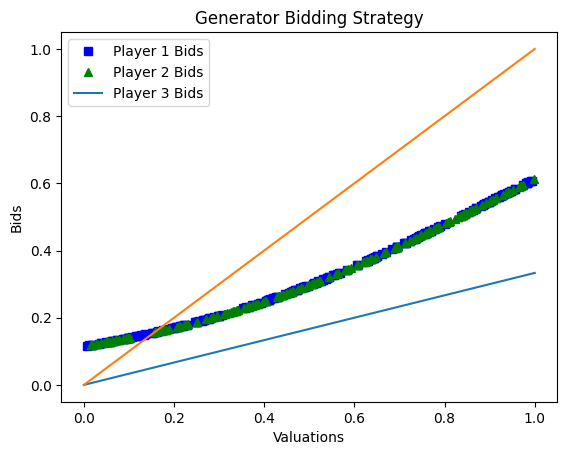

In [ ]:
NUM_TEST_SAMPLES = 200

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
p3_input = jax.random.uniform(jax.random.PRNGKey(3), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input, p3_input), axis=1)

output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
p1_output = output[:, 0]
p2_output = output[:, 1]
p3_output = output[:, 2]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
# plt.plot(p3_input, p3_output, 'p-')
plt.plot([0,1], [0,1/3])
plt.plot([0,1], [0,1])


plt.title("Generator Bidding Strategy")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Bids")
plt.legend(["Player 1 Bids", "Player 2 Bids", "Player 3 Bids"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen+disconnectedDisc.png")
# files.download("disconnectedGen+disconnectedDisc.png")

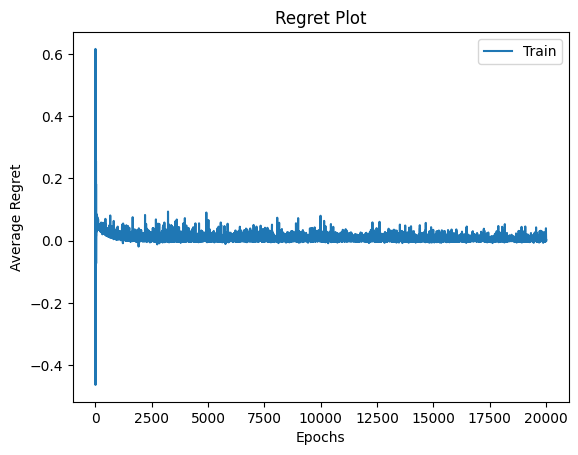

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Regret")
plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen+disconnectedDisc_Regret.png")
# files.download("disconnectedGen+disconnectedDisc_Regret.png")

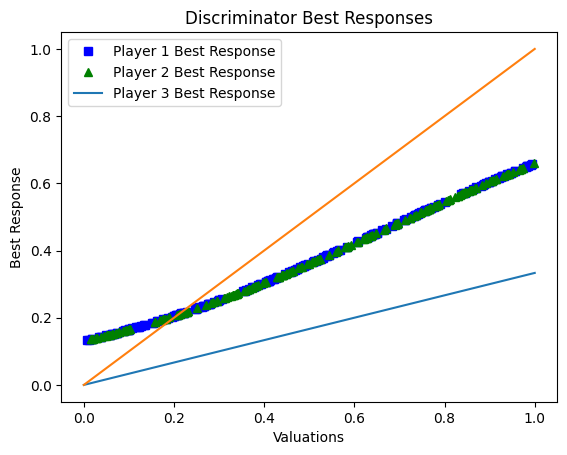

In [ ]:
NUM_TEST_SAMPLES = 200

p1_input = jax.random.uniform(jax.random.PRNGKey(1), shape=(NUM_TEST_SAMPLES, 1))
p2_input = jax.random.uniform(jax.random.PRNGKey(2), shape=(NUM_TEST_SAMPLES, 1))
p3_input = jax.random.uniform(jax.random.PRNGKey(3), shape=(NUM_TEST_SAMPLES, 1))
input = jnp.concatenate((p1_input, p2_input, p3_input), axis=1)

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(NUM_TEST_SAMPLES, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
p1_output = disc_output[:, 0]
p2_output = disc_output[:, 1]
p3_output = disc_output[:, 2]

plt.plot(p1_input, p1_output, 'bs')
plt.plot(p2_input, p2_output, 'g^')
# plt.plot(p3_input, p3_output, 'r')
plt.plot([0,1], [0,1/3])
plt.plot([0,1], [0,1])


plt.title("Discriminator Best Responses")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
plt.xlabel("Valuations")
plt.ylabel("Best Response")
plt.legend(["Player 1 Best Response", "Player 2 Best Response", "Player 3 Best Response"], loc="upper left")
# plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen+disconnectedDisc_disc.png")
# files.download("disconnectedGen+disconnectedDisc_disc.png")

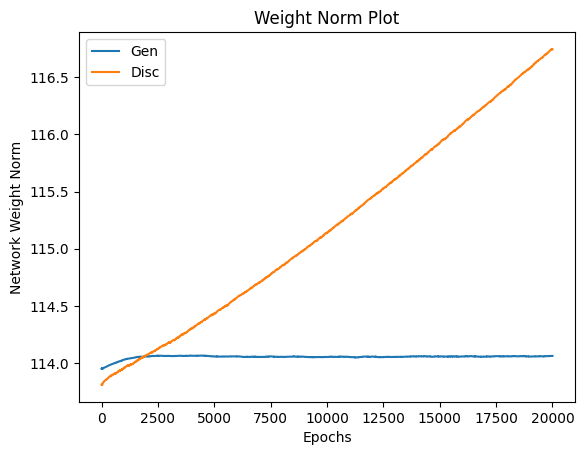

In [ ]:
plt.title("Weight Norm Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_weight_norm"], label="Gen")
plt.plot(range(1, GEN_EPOCHS+1), log["disc_weight_norm"], label="Disc")
plt.xlabel("Epochs")
plt.ylabel("Network Weight Norm")
plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen+disconnectedDisc_Weights.png")
# files.download("disconnectedGen+disconnectedDisc_Weights.png")

## w/ Budget Constraints

In [ ]:
# Hard coded for 2 players, one good
class DisconnectedGenerator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of valuations and budgets. Shape is
        (num_batches, 2, 2)
    Returns:
      bids: A jnp.array of bids. Shape is
        (num_batches, 2)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    network = hk.Sequential([
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1), jax.nn.sigmoid
    ])

    p1_bid = jnp.reshape(
        network(jnp.reshape(batch[:, 0], (num_batches, -1))),
        (num_batches, 1)
    )
    p2_bid = jnp.reshape(
        network(jnp.reshape(batch[:, 1], (num_batches, -1))),
        (num_batches, 1)
    )

    bids = jnp.concatenate((p1_bid, p2_bid), axis=1)

    return bids


In [ ]:
class DisconnectedDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, bids):
    """Gives a predicted equilibirum action profile.
    Args:
      batch: A jnp.array of valuations and budgets. Shape is
        (num_batches, 2, 2)
      bids: A jnp.array of bids. Shape is (num_batches, 2)
    Returns:
      response: A jnp.array of best response bids. Shape is
        (num_batches, 2)
    """
    num_batches = jnp.shape(batch)[0]
    num_players = jnp.shape(batch)[1]

    # allocation = inflated_softmax(bids, 10000)
    # valuations = jnp.reshape(batch[:, :, 0], (num_batches, num_players))
    # budgets = jnp.reshape(batch[:, :, 1], (num_batches, num_players))
    # utils = allocation * (valuations - bids)
    # payments = allocation * bids

    # input should be their valuation, their bid, thier util, all payments, all allocations
    x_1 = jnp.reshape(batch[:, 0], (num_batches, -1))
    x_2 = jnp.reshape(batch[:, 1], (num_batches, -1))

    network = hk.Sequential([
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1024), jax.nn.softplus,
        hk.Linear(1), jax.nn.sigmoid,
    ])

    p1_response = jnp.reshape(network(x_1), (num_batches, 1))
    p2_response = jnp.reshape(network(x_2), (num_batches, 1))
    x = jnp.concatenate((p1_response, p2_response), axis=1)

    return x

In [ ]:
@jax.jit
def distribution(rng, num_samples, params):
  return None

@jax.jit
def regret_func(action, response, batch, c=1.01, ):
  num_batches = jnp.shape(batch)[0]
  num_players = jnp.shape(batch)[1]

  valuations = jnp.reshape(batch[:, :, 0], (num_batches, num_players))
  budgets = jnp.reshape(batch[:, :, 1], (num_batches, num_players))
  action_allocation = inflated_softmax(action, 10000) # shape=(num_batches, 2)
  action_util = action_allocation * (valuations - action)
  action_util = action_util - 0.05

  x_1_new_bids = jnp.stack((response[:,0], action[:,1]), axis=-1)
  x_2_new_bids = jnp.stack((action[:,0], response[:,1]), axis=-1)
  x_1_alloc = inflated_softmax(x_1_new_bids, 10000)
  x_2_alloc = inflated_softmax(x_2_new_bids, 10000)
  x_1_util = x_1_alloc * (valuations - x_1_new_bids)
  x_2_util = x_2_alloc * (valuations - x_2_new_bids)
  response_util = jnp.stack((x_1_util[:,0], x_2_util[:,1]), axis=-1)

  response_util = response_util - 0.05

  # Augmented Lagrangian Addition

  regret = jnp.mean(jnp.sum(response_util - action_util, axis=1))

  return regret

### Disconnected Gen + Disconnected Disc

In [ ]:
NUM_SAMPLES = 2000
GEN_EPOCHS = 100
DISC_EPOCHS = 1
BATCH_SIZE = 50

valuations = jax.random.uniform(jax.random.PRNGKey(0), shape=(NUM_SAMPLES, 2, 1))
budgets = jax.random.choice(jax.random.PRNGKey(0), a=jnp.array([0.25,0.75]), shape=(NUM_SAMPLES, 2, 1))
data = jnp.concatenate((valuations, budgets), axis=2)
train_data, test_data = data[:1900], data[1900:]

SimpleGen = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedGenerator()(*args)))
SimpleDisc = hk.without_apply_rng(hk.transform(lambda *args: DisconnectedDiscriminator()(*args)))

Test_GAES_1 = GAES(SimpleGen,
                   SimpleDisc,
                   optax.adam(1e-5), # maybe change
                   optax.adam(1e-5),
                   distribution,
                   regret_func)

Test_GAES_1.setup_custom_data(train_data, test_data)
print(train_data[:BATCH_SIZE].shape)
gaes_state = Test_GAES_1.init_state(jax.random.PRNGKey(0), train_data[:BATCH_SIZE])



gaes_state, log = Test_GAES_1.train(gaes_state,
                                    GEN_EPOCHS,
                                    DISC_EPOCHS,
                                    BATCH_SIZE)

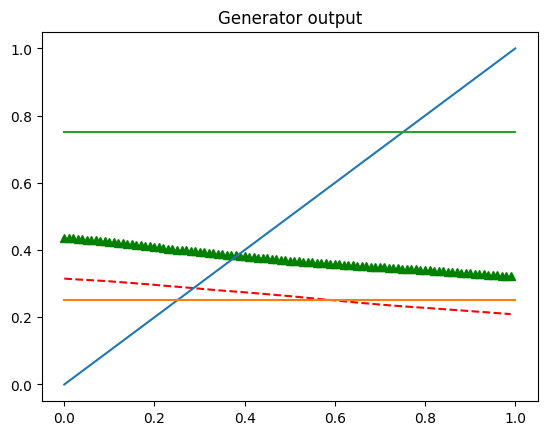

In [ ]:
high_budget_input = jnp.expand_dims(jnp.stack((jnp.arange(0, 1, 0.01), jnp.repeat(0.75, 100)), axis=-1), axis=1)
low_budget_input = jnp.expand_dims(jnp.stack((jnp.arange(0, 1, 0.01), jnp.repeat(0.25, 100)), axis=-1), axis=1)
input = jnp.concatenate((high_budget_input, low_budget_input), axis=1) # see if this works

output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(num_samples, 2)
high_budget_output = output[:, 0]
low_budget_output = output[:, 1]

plt.plot(jnp.arange(0, 1, 0.01), high_budget_output, 'r--')
plt.plot(jnp.arange(0, 1, 0.01), low_budget_output, 'g^')
plt.plot([0,1], [0,1])
plt.plot([0,1], [0.25,0.25])
plt.plot([0,1], [0.75,0.75])


plt.title("Generator output")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Average Exploitability")
# plt.legend(loc='best')
plt.show()
# plt.savefig("gaes_excon_loss_graph.png")
# files.download("gaes_excon_loss_graph.png")

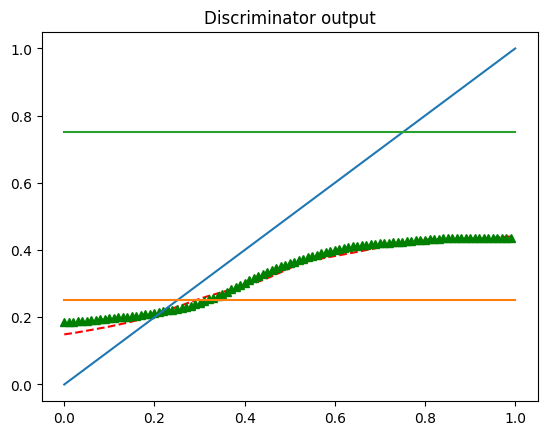

In [ ]:
high_budget_input = jnp.expand_dims(jnp.stack((jnp.arange(0, 1, 0.01), jnp.repeat(0.75, 100)), axis=-1), axis=1)
low_budget_input = jnp.expand_dims(jnp.stack((jnp.arange(0, 1, 0.01), jnp.repeat(0.25, 100)), axis=-1), axis=1)
input = jnp.concatenate((high_budget_input, low_budget_input), axis=1) # see if this works

gen_output = SimpleGen.apply(gaes_state.params.gen, input) # shape=(num_samples, 2)
disc_output = SimpleDisc.apply(gaes_state.params.disc, input, gen_output)
high_budget_br = disc_output[:, 0]
low_budget_br = disc_output[:, 1]

plt.plot(jnp.arange(0, 1, 0.01), high_budget_br, 'r--')
plt.plot(jnp.arange(0, 1, 0.01), low_budget_br, 'g^')
plt.plot([0,1], [0,1])
plt.plot([0,1], [0.25,0.25])
plt.plot([0,1], [0.75,0.75])

plt.title("Discriminator output")
# plt.plot(range(1, GEN_EPOCHS + 1), log["train_exploitability"], label="Train Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Average Exploitability")
# plt.legend(loc='best')
plt.show()
# plt.savefig("gaes_excon_loss_graph.png")
# files.download("gaes_excon_loss_graph.png")

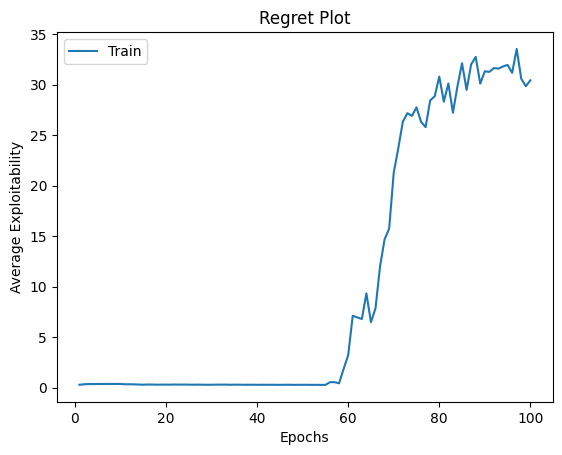

In [ ]:
plt.title("Regret Plot")
plt.plot(range(1, GEN_EPOCHS+1), log["gen_loss"], label="Train")
# plt.plot(epochs_range, log["test_exploitability"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Average Exploitability")
plt.legend(loc='best')
# plt.show()
# plt.savefig("disconnectedGen_Disc_Regret.png")
# files.download("disconnectedGen_Disc_Regret.png")

# Fisher Markets

In [ ]:
# Amy's min-max formulation

class AmyGenerator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, *args, **kwargs):
    budgets = batch["budget"]
    valuations = batch["valuation"]

    num_batches, num_players, num_goods = jnp.shape(valuations)

    allocation_input = jnp.concatenate(
       (jnp.reshape(budgets, (num_batches, -1)),
        jnp.reshape(valuations, (num_batches, -1))),
       axis=1
    )

    allocation_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear((num_players + 1) * num_goods)
    ])

    allocation = jnp.reshape(allocation_network(allocation_input), (num_batches, num_players + 1, num_goods))
    allocation = jax.nn.softmax(allocation, axis=1)
    allocation = allocation[:, :-1 :]

    # first find price vector
    price_input = jnp.concatenate(
        (jnp.reshape(budgets, (num_batches, -1)),
         jnp.reshape(valuations, (num_batches, -1))), # price should be response to allocations
        axis=1
    )

    price_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.softplus # so its non-negative
    ])

    prices = jnp.reshape(price_network(price_input), (num_batches, num_goods))

    # Now find allocation matrix

    return (prices, allocation)

class AmyDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, action, *args, **kwargs):
    budgets = batch["budget"]
    valuations = batch["valuation"]
    prices, allocation = action

    num_batches, num_players, num_goods = jnp.shape(valuations)

    # Now find allocation matrix
    br_allocation_input = jnp.concatenate(
       (jnp.reshape(budgets, (num_batches, -1)),
        jnp.reshape(valuations, (num_batches, -1)),
        jnp.reshape(prices, (num_batches, -1))),
       axis=1
    )

    br_allocation_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear((num_players + 1) * num_goods)
    ])

    br_allocation = jnp.reshape(br_allocation_network(br_allocation_input), (num_batches, num_players + 1, num_goods))
    br_allocation = jax.nn.softmax(br_allocation, axis=1)
    br_allocation = br_allocation[:, :-1 :]

    # first find price vector
    br_price_input = jnp.concatenate(
        (jnp.reshape(budgets, (num_batches, -1)),
         jnp.reshape(valuations, (num_batches, -1)),
         jnp.reshape(allocation, (num_batches, -1))),
        axis=1
    )

    br_price_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.softplus
    ])

    br_prices = jnp.reshape(br_price_network(br_price_input), (num_batches, num_goods))

    return (br_prices, br_allocation)


In [ ]:
# Jay's min-max formulation

class JayGenerator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, *args, **kwargs):
    budgets = batch["budget"]
    valuations = batch["valuation"]

    num_batches, num_players, num_goods = jnp.shape(valuations)

    allocation_input = jnp.concatenate(
       (jnp.reshape(budgets, (num_batches, -1)),
        jnp.reshape(valuations, (num_batches, -1))),
       axis=1
    )

    allocation_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear((num_players + 1) * num_goods)
    ])

    allocation = jnp.reshape(allocation_network(allocation_input), (num_batches, num_players + 1, num_goods))
    allocation = jax.nn.softmax(allocation, axis=1)
    allocation = allocation[:, :-1 :]

    # first find price vector
    price_input = jnp.concatenate(
        (jnp.reshape(budgets, (num_batches, -1)),
         jnp.reshape(valuations, (num_batches, -1))), # price should be response to allocations
        axis=1
    )

    price_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.softplus # so its non-negative
    ])

    prices = jnp.reshape(price_network(price_input), (num_batches, num_goods))

    # Now find allocation matrix

    return (allocation, prices)

class JayDiscriminator(hk.Module):

  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, batch, action, *args, **kwargs):
    budgets = batch["budget"]
    valuations = batch["valuation"]
    allocation, prices = action

    num_batches, num_players, num_goods = jnp.shape(valuations)

    # Now find allocation matrix
    br_allocation_input = jnp.concatenate(
       (jnp.reshape(budgets, (num_batches, -1)),
        jnp.reshape(valuations, (num_batches, -1)),
        jnp.reshape(allocation, (num_batches, -1))), # trying to beat prev allocation
       axis=1
    )

    br_allocation_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear((num_players + 1) * num_goods)
    ])

    br_allocation = jnp.reshape(br_allocation_network(br_allocation_input), (num_batches, num_players + 1, num_goods))
    br_allocation = jax.nn.softmax(br_allocation, axis=1)
    br_allocation = br_allocation[:, :-1 :]

    # first find price vector
    br_price_input = jnp.concatenate(
        (jnp.reshape(budgets, (num_batches, -1)),
         jnp.reshape(valuations, (num_batches, -1)),
         jnp.reshape(prices, (num_batches, -1))), # trying to beat prev prices
        axis=1
    )

    br_price_network = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(num_goods), jax.nn.softplus
    ])

    br_prices = jnp.reshape(br_price_network(br_price_input), (num_batches, num_goods))

    return (br_allocation, br_prices)

In [ ]:
UTIL_TYPE = 'cobb-douglas'
NUM_BUYERS = 2
NUM_GOODS = 1

In [ ]:
def buyer_util(valuations, allocation):
  util_type = UTIL_TYPE
  if util_type == 'linear':
    return jnp.sum(allocation * valuations, axis=-1) # sum over goods
  elif util_type == "cobb-douglas":
    return jnp.prod(allocation ** valuations, axis=-1)
  elif util_type == 'leontief':
    return jnp.min(allocation * valuations, axis=-1)

  return None

def indirect_util(prices, budgets):
  util_type = UTIL_TYPE
  if util_type == 'linear':
    return 1
  elif util_type == "cobb-douglas":
    return 1
  elif util_type == 'leontief':
    return 1

def amys_objective_regret(action, response, batch):
  prices, allocation = action
  br_prices, br_allocation = response
  budgets = batch["budget"]
  valuations = batch["valuation"]

  num_batches, num_players, num_goods = jnp.shape(valuations)

  util_diff = jnp.sum(
      budgets * jnp.log(buyer_util(valuations, br_allocation) / buyer_util(valuations, allocation)),
      axis=-1
  )
  price_constraint = jnp.sum(
      prices * (jnp.sum(br_allocation, axis=1) - jnp.ones((num_batches, num_goods))),
      axis=-1
  )
  br_price_constraint = jnp.sum(
      br_prices * (jnp.sum(allocation, axis=1) - jnp.ones((num_batches, num_goods))),
      axis=-1
  )

  regret = jnp.mean(util_diff - price_constraint + br_price_constraint)

  return regret

def jays_objective_regret(action, response, batch):
  allocation, prices = action
  br_allocation, br_prices = response
  budgets = batch["budget"]
  valuations = batch["valuation"]

  num_batches, num_players, num_goods = jnp.shape(valuations)

  util_diff = jnp.sum(
      budgets * jnp.log(buyer_util(valuations, br_allocation) / buyer_util(valuations, allocation)),
      axis=-1
  )

  price_diff = jnp.sum(
      prices - br_prices,
      axis=-1

  )

  # should have a budget vector of 1????
  indirect_util_diff = jnp.sum(
      budgets * jnp.log(indirect_util(prices, jnp.ones(budgets.shape)) / indirect_util(br_prices, jnp.ones(budgets.shape))),
      axis=-1
  )

  return jnp.mean(util_diff + price_diff + indirect_util_diff)


In [ ]:
def distribution(rng, num_samples, params={}):
  # hard code number of buyers and goods
  num_buyers = NUM_BUYERS
  num_goods = NUM_GOODS

  budget_key, val_key = jax.random.split(rng, 2)
  budgets = jax.random.uniform(
      budget_key,
      shape=(num_samples, num_buyers),
      minval = 1e-8,
      maxval = 1.0
  )
  valuations = jax.random.uniform(
      val_key,
      shape=(num_samples, num_buyers, num_goods),
      minval = 1e-8,
      maxval = 1.0
  )

  batch = {
      "valuation": valuations,
      "budget": budgets
  }

  return batch

In [ ]:
# Simple one sample game
valuations = jnp.ones((1, 1, 1))
budgets = jnp.ones((1, 1))
batch = {
    "valuation": valuations,
    "budget": budgets
}

## One Sample, One Game

In [ ]:
BATCH_SIZE = 1
GEN_EPOCHS = 1000
DISC_EPOCHS = 100

epochs_range = range(1, 1 + GEN_EPOCHS)

In [ ]:
Generator = hk.without_apply_rng(hk.transform_with_state(lambda *args: AmyGenerator()(*args)))
Discriminator = hk.without_apply_rng(hk.transform_with_state(lambda *args: AmyDiscriminator()(*args)))

Solver = GAES(Generator,
               Discriminator,
               optax.sgd(1e-4),
               optax.sgd(1e-4),
               distribution,
               amys_objective_regret)

Solver.setup_custom_data(batch, batch, 1, 1)
gaes_state = Solver.init_state(jax.random.PRNGKey(0), batch)

gaes_state, log = Solver.train(
    gaes_state,
    GEN_EPOCHS,
    DISC_EPOCHS,
    BATCH_SIZE
)


Outer Training Epoch 1 Completed
Outer Training Epoch 100 Completed
Outer Training Epoch 200 Completed
Outer Training Epoch 300 Completed
Outer Training Epoch 400 Completed
Outer Training Epoch 500 Completed
Outer Training Epoch 600 Completed
Outer Training Epoch 700 Completed
Outer Training Epoch 800 Completed
Outer Training Epoch 900 Completed
Outer Training Epoch 1000 Completed


In [ ]:
outcome, state = Generator.apply(gaes_state.params.gen, gaes_state.state.gen, batch) # (params, state, batch, boolean)
br_outcome, br_state = Discriminator.apply(gaes_state.params.disc, gaes_state.state.disc, batch, outcome)
allocation, prices = outcome
print(allocation)
print(prices)

br_allocation, br_prices = br_outcome
print(br_allocation)
print(br_prices)

[[0.6700683]]
[[[0.9412635]]]
[[0.00230981]]
[[[0.99922633]]]
